# **Introduction to Python for Economists** <br>
**Authors**: Marco Valentino Caravella (0001134954), Damiano Mongiello (0001129786) <br>
**Date**: 20/01/2025

In [1069]:
%reset -f

In [1070]:
import pandas as pd 
import os
import geopandas as gpd 
import matplotlib.pyplot as plt 
from shapely.geometry import Point 
from shapely.geometry import box
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import matplotlib
import numpy as np
from linearmodels.panel import PanelOLS
import statsmodels.api as sm

## **Graphical Data Visualization**

We start by loading all the datasets needed for the research analysis, and proceed with the data cleaning operations.

### **Dataset Preparation: Cleaning and Filtering for Graphical Visualization**

In [1073]:
# Set the working directory
os.chdir('C:/Users/user/Documents/Unibo/Economics and Econometrics/Second Year/First Semester/Introduction to Python for Economists/Project')

# Load Nuclear Plants data
nuclear_plants = pd.read_csv('nuclear_power_plants.csv') # Data from "https://github.com/cristianst85/GeoNuclearData/blob/master/data/csv/denormalized/nuclear_power_plants.csv"
print(nuclear_plants.head())

# Consider only nuclear plants that are already operative
operational_nuclear_plants = ["Operational"]
nuclear_plants = nuclear_plants[nuclear_plants['Status'].isin(operational_nuclear_plants)]
print(nuclear_plants.head())

   Id                  Name   Latitude  Longitude Country CountryCode  \
0   1                Ågesta  59.206000   18.08290  Sweden          SE   
1   2  Akademik Lomonosov-1  69.709579  170.30625  Russia          RU   
2   3  Akademik Lomonosov-2  69.709579  170.30625  Russia          RU   
3   4              Akhvaz-1        NaN        NaN    Iran          IR   
4   5              Akhvaz-2        NaN        NaN    Iran          IR   

        Status ReactorType        ReactorModel ConstructionStartAt  \
0     Shutdown        PHWR                 NaN          1957-12-01   
1  Operational         PWR  KLT-40S 'Floating'          2007-04-15   
2  Operational         PWR  KLT-40S 'Floating'          2007-04-15   
3      Planned         NaN                 NaN                 NaN   
4      Planned         NaN                 NaN                 NaN   

  OperationalFrom OperationalTo  Capacity              LastUpdatedAt  \
0      1964-05-01    1974-06-02       9.0  2015-05-24T04:51:37+03:00

In [1074]:
# Filter rows where "OperationalFrom" is NA
na_rows = nuclear_plants[nuclear_plants["OperationalFrom"].isna()]

print("Observations with NA values in 'OperationalFrom':")
print(na_rows) # Mochovce-3 is now under construction. Thus, we will ignore it 

# Create a vector of EU countries
eu_iso2_codes = [
    "AT", "BE", "BG", "HR", "CY",
    "CZ", "DK", "EE", "FI", "FR",
    "DE", "GR", "HU", "IE", "IT",
    "LV", "LT", "LU", "MT", "NL",
    "PL", "PT", "RO", "SK", "SI",
    "ES", "SE"
]

# Filter for EU countries
nuclear_plants = nuclear_plants[nuclear_plants['CountryCode'].isin(eu_iso2_codes)]

# Convert the operational and decommission dates to datetime
nuclear_plants['OperationalFrom'] = pd.to_datetime(nuclear_plants['OperationalFrom'])
nuclear_plants['OperationalTo'] = pd.to_datetime(nuclear_plants['OperationalTo'])

# Check for null or missing values in the dates
print(nuclear_plants[['OperationalFrom', 'OperationalTo']].isnull().sum())

# Drop 
nuclear_plants.dropna(subset=["OperationalFrom"], inplace=True) # We droped only the observations with OperationalFrom=NaN

Observations with NA values in 'OperationalFrom':
      Id                                    Name   Latitude   Longitude  \
119  121  CEFR (China Experimental Fast Reactor)  39.739000  116.030000   
356  358                              Kakrapar-3  21.236000   73.351000   
460  462                              Mochovce-3  48.261000   18.455000   
623  625                            Shin-Hanul-2  37.083889  129.391667   

         Country CountryCode       Status ReactorType ReactorModel  \
119        China          CN  Operational         FBR        BN-20   
356        India          IN  Operational        PHWR     PHWR-700   
460     Slovakia          SK  Operational         PWR   VVER V-213   
623  South Korea          KR  Operational         PWR     APR-1400   

    ConstructionStartAt OperationalFrom OperationalTo  Capacity  \
119          2000-05-10             NaN           NaN      20.0   
356          2010-11-22             NaN           NaN     630.0   
460          1987-01-2

In [1075]:
# Create a GeoDataFrame for nuclear plants
plants_gdf = gpd.GeoDataFrame(
    nuclear_plants, geometry=gpd.points_from_xy(nuclear_plants.Longitude, nuclear_plants.Latitude), crs="EPSG:4326")
print(type(plants_gdf))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [1076]:
# Load the shapefile for NUTS3 regions
sp_path = "NUTS_RG_01M_2021_4326_LEVL_3/NUTS_RG_01M_2021_4326_LEVL_3_repaired.shp"  
eu_map = gpd.read_file(sp_path)

# Define the bounding box for continental Europe (otherwise we would have Overseas France territories)
bounding_box = {
    "minx": -10,  # Western limit
    "maxx": 30,   # Eastern limit
    "miny": 35,   # Southern limit
    "maxy": 70    # Northern limit
}

# Filter for EU countries
eu_map = eu_map[eu_map['CNTR_CODE'].isin(eu_iso2_codes)]

# Create a bounding box as a shapely object
bounding_polygon = box(bounding_box["minx"], bounding_box["miny"], bounding_box["maxx"], bounding_box["maxy"])

# Clip the map using the bounding box
eu_map = eu_map.clip(bounding_polygon)

print(eu_map)
print(eu_map.crs)

    NUTS_ID  LEVL_CODE CNTR_CODE                    NAME_LATN  \
315   BG425          3        BG                    Kardzhali   
371   BG424          3        BG                      Smolyan   
212   BG413          3        BG                  Blagoevgrad   
413   BG422          3        BG                      Haskovo   
370   BG423          3        BG                   Pazardzhik   
..      ...        ...       ...                          ...   
293   DEF07          3        DE                Nordfriesland   
617   DEF01          3        DE  Flensburg, Kreisfreie Stadt   
651   DK032          3        DK                   Sydjylland   
576   DK041          3        DK                  Vestjylland   
765   DK050          3        DK                  Nordjylland   

                       NUTS_NAME  MOUNT_TYPE  URBN_TYPE  COAST_TYPE    FID  \
315                     ????????         3.0        3.0           3  BG425   
371                       ??????         3.0        3.0        

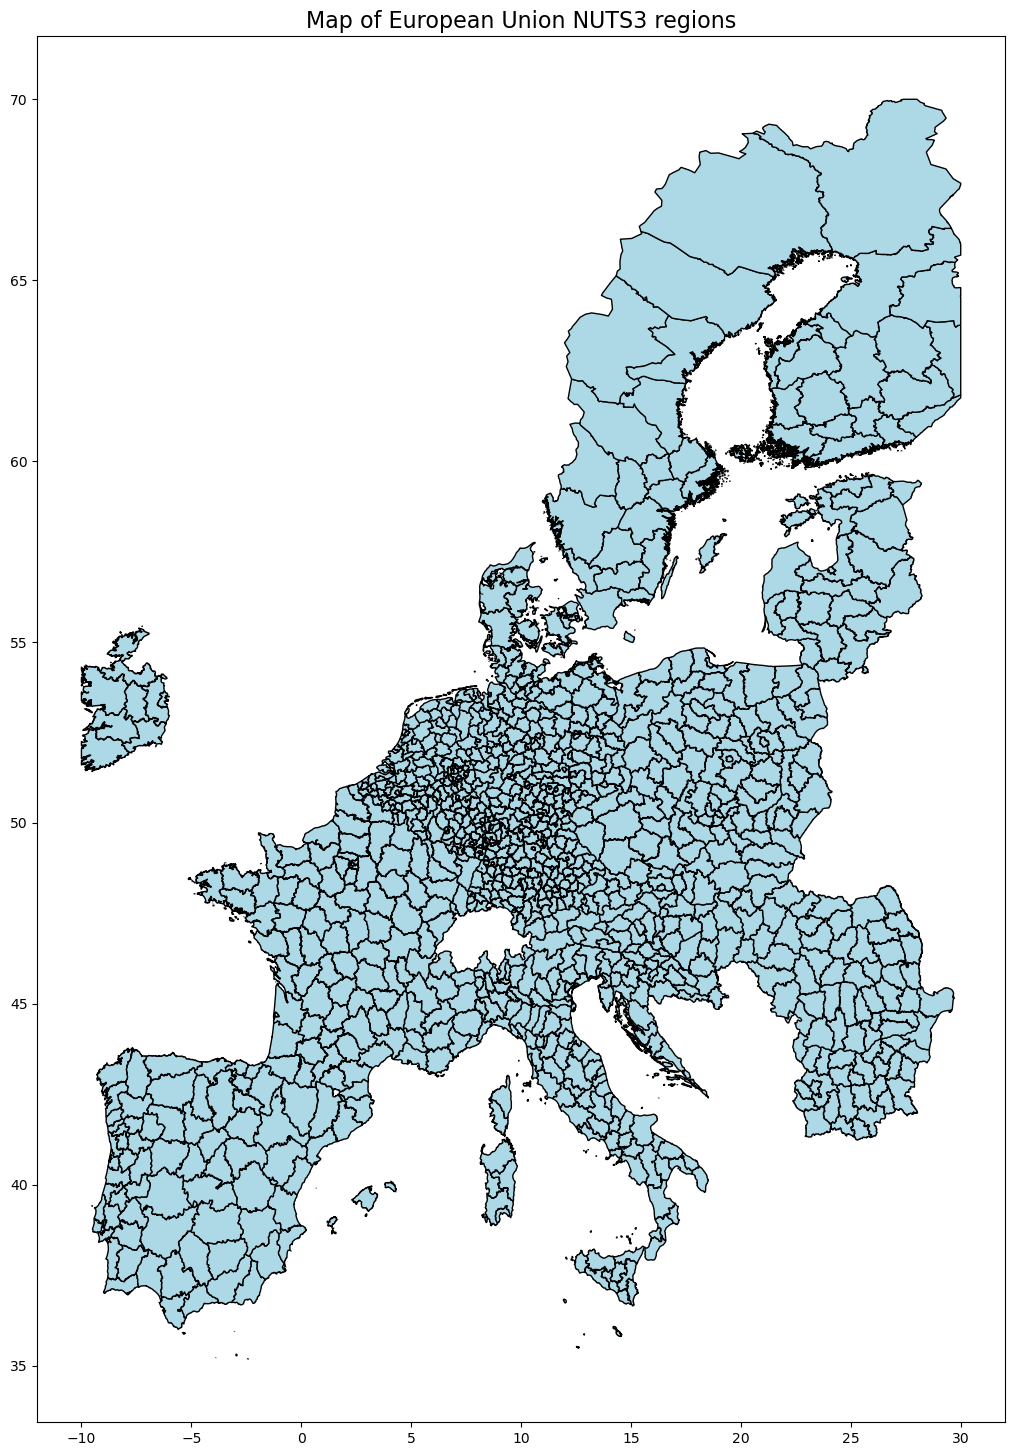

In [1077]:
# Plot EU countries
fig, ax = plt.subplots(figsize=(18, 18))
eu_map.plot(ax=ax, color="lightblue", edgecolor="black")

# Add a title
ax.set_title("Map of European Union NUTS3 regions", fontsize=16)

# Show the plot
plt.show()

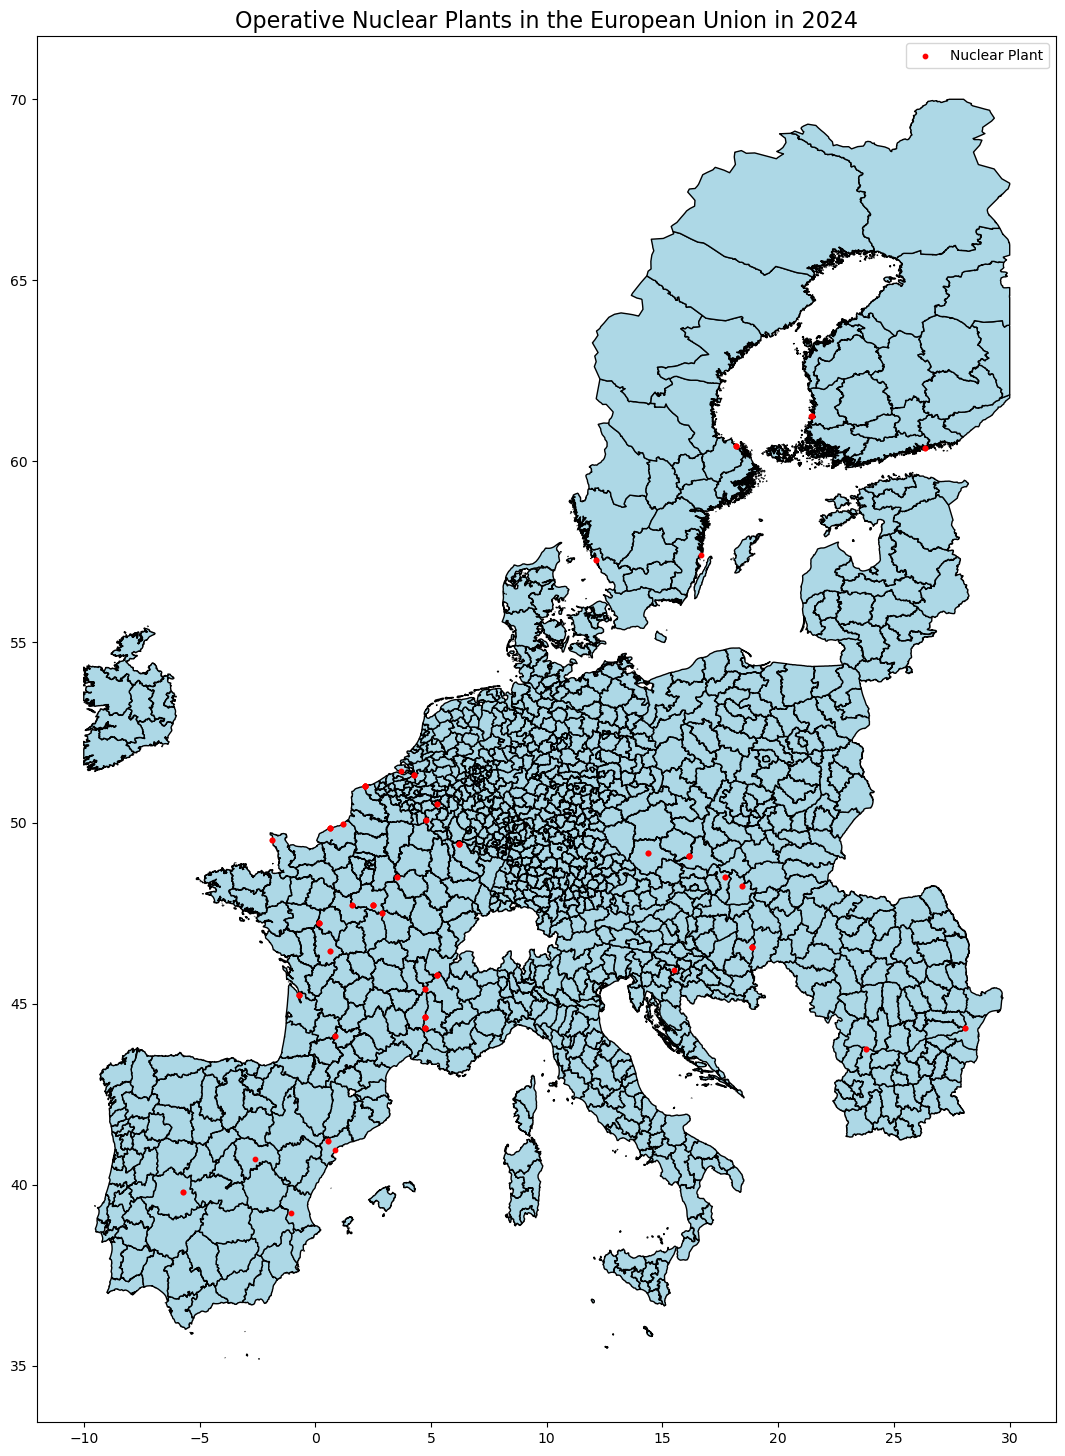

In [1078]:
# Plot EU countries with nuclear plants
fig, ax = plt.subplots(figsize=(18, 18))
eu_map.plot(ax=ax, color="lightblue", edgecolor="black")
plants_gdf.plot(ax=ax, color="red", markersize=10, label="Nuclear Plant")

# Add title and legend
ax.set_title("Operative Nuclear Plants in the European Union in 2024", fontsize=16)
ax.legend()

# Save the plots
plt.savefig("nuclear_plants_eu_map.png", bbox_inches="tight")

# Show the plot
plt.show()

In [1079]:
# Load GDP data
gdp = pd.read_csv("estat_nama_10r_3gdp.tsv.gz", sep="\t", compression="gzip")

# Split the combined column into separate columns
gdp_split = gdp['freq,unit,geo\\TIME_PERIOD'].str.split(',', expand=True)

# Assign meaningful names to the new columns
gdp_split.columns = ['freq', 'unit', 'geo']

# Merge the split columns back into the original DataFrame
gdp = pd.concat([gdp, gdp_split], axis=1)

# Drop the original combined column (optional)
gdp.drop(columns=['freq,unit,geo\\TIME_PERIOD'], inplace=True)

# Step 1: Filter 'gdp' to keep only relevant rows
relevant_gdp = gdp[gdp['geo'].isin(eu_map['NUTS_ID'])]

# Step 2: Merge the filtered 'gdp' with 'eu_map'
merged = eu_map.merge(relevant_gdp, left_on="NUTS_ID", right_on="geo", how="right")

print(merged.head())
print(type(merged))

  NUTS_ID  LEVL_CODE CNTR_CODE                NAME_LATN  \
0   AT111          3        AT         Mittelburgenland   
1   AT112          3        AT           Nordburgenland   
2   AT113          3        AT            Südburgenland   
3   AT121          3        AT  Mostviertel-Eisenwurzen   
4   AT122          3        AT     Niederösterreich-Süd   

                 NUTS_NAME  MOUNT_TYPE  URBN_TYPE  COAST_TYPE    FID  \
0         Mittelburgenland         4.0        3.0           3  AT111   
1           Nordburgenland         4.0        3.0           3  AT112   
2            Südburgenland         4.0        3.0           3  AT113   
3  Mostviertel-Eisenwurzen         2.0        3.0           3  AT121   
4     Niederösterreich-Süd         3.0        2.0           3  AT122   

                                            geometry  ...   2016    2017   \
0  POLYGON ((16.63552 47.44531, 16.62806 47.44207...  ...  24500   26500    
1  POLYGON ((17.13656 47.9951, 17.09466 47.97087,...  ... 

In [1080]:
# Restrict the data for the years between 2001 and 2022
years = ["2001", "2002","2003","2004","2005","2006","2007","2008","2009","2010","2011","2012","2013","2014","2015",
        "2016", "2017", "2018","2019","2020","2021", "2022"]  # List of year columns as strings

# Strip any leading or trailing whitespace from column names
merged.columns = merged.columns.str.strip()

for year in years:
    merged[year] = merged[year].astype(str).str.strip() # Clean non-numeric characters and spaces
    merged[year] = merged[year].str.replace(r"[^\d.]", "", regex=True)  # Keep only numbers and decimal points
    merged[year] = pd.to_numeric(merged[year], errors="coerce").fillna(0) # Convert to numeric and fill missing values with 0

print(merged.dtypes)

NUTS_ID         object
LEVL_CODE        int32
CNTR_CODE       object
NAME_LATN       object
NUTS_NAME       object
MOUNT_TYPE     float64
URBN_TYPE      float64
COAST_TYPE       int32
FID             object
geometry      geometry
2000            object
2001           float64
2002           float64
2003           float64
2004           float64
2005           float64
2006           float64
2007           float64
2008           float64
2009           float64
2010           float64
2011           float64
2012           float64
2013           float64
2014           float64
2015           float64
2016           float64
2017           float64
2018           float64
2019           float64
2020           float64
2021           float64
2022           float64
freq            object
unit            object
geo             object
dtype: object


In [1081]:
# Transform the data from wide to long format
merged_long = pd.melt(
    merged,
    id_vars=["NUTS_ID", "geometry", "geo"], # Keep these as identifiers
    value_vars=years, # Only "melt" the year columns
    var_name="year", # Column for years
    value_name="GDP" # Column for GDP values
)

# Check for missing values
print(merged_long['GDP'].isna().sum())
print(merged_long)

0
       NUTS_ID                                           geometry    geo  \
0        AT111  POLYGON ((16.63552 47.44531, 16.62806 47.44207...  AT111   
1        AT112  POLYGON ((17.13656 47.9951, 17.09466 47.97087,...  AT112   
2        AT113  POLYGON ((16.44414 47.34632, 16.44847 47.33988...  AT113   
3        AT121  POLYGON ((15.51229 48.3102, 15.52049 48.31099,...  AT121   
4        AT122  POLYGON ((15.93363 48.07037, 15.94567 48.06833...  AT122   
...        ...                                                ...    ...   
169241   SK023  POLYGON ((18.48865 48.54371, 18.49339 48.53502...  SK023   
169242   SK031  POLYGON ((19.47421 49.60408, 19.46944 49.5964,...  SK031   
169243   SK032  POLYGON ((19.99554 48.90483, 20.01669 48.90102...  SK032   
169244   SK041  POLYGON ((21.40376 49.43197, 21.40906 49.42539...  SK041   
169245   SK042  MULTIPOLYGON (((22.37915 48.83927, 22.37678 48...  SK042   

        year      GDP  
0       2001  16500.0  
1       2001  19600.0  
2       2001 

In [1082]:
# Convert the 'year' column to integers
merged_long['year'] = merged_long['year'].astype(int)
print(merged_long.dtypes)

NUTS_ID       object
geometry    geometry
geo           object
year           int32
GDP          float64
dtype: object


In [1083]:
# Save the DataFrame as an Excel file
merged_long.to_excel("GDP2001_2022.xlsx", index=False, engine="openpyxl")

### **Graphical Visualization**  <br>
#### **EU countries**
We plot GDP values and the position of EU nuclear plants in 2020:

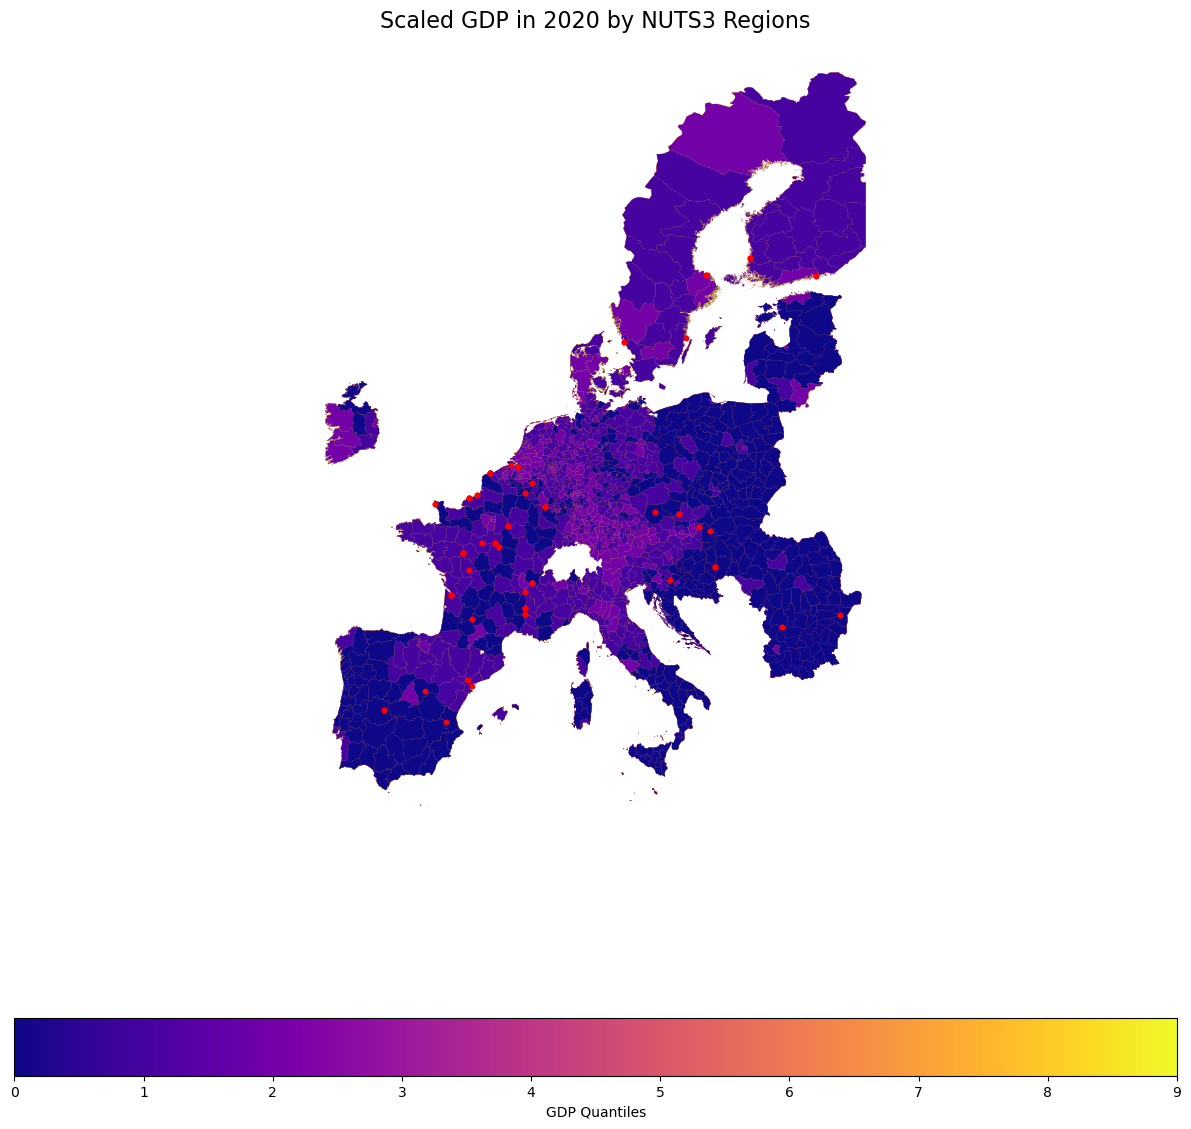

In [1085]:
# First we need to transform merged_long from Data.Frame into GeoData.Frame
merged_long = gpd.GeoDataFrame(merged_long, geometry="geometry")

# We filter for year 2022
merged_long2022 = merged_long[merged_long['year'] == 2020].copy()

# Normalize GDP values to the range 0–1
merged_long2022.loc[:, "Scaled_GDP"] = (merged_long2022["GDP"] - merged_long2022["GDP"].min()) / (merged_long2022["GDP"].max() - merged_long2022["GDP"].min())
merged_long2022.loc[:, "Scaled_GDP"] = pd.qcut(merged_long2022["Scaled_GDP"], q=10, labels=False)
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
merged_long2022.plot(
column="Scaled_GDP",
cmap="plasma",
legend=True,
ax=ax,
legend_kwds={"label": "GDP Quantiles","orientation": "horizontal"}
)
plants_gdf.plot(ax=ax, color="red", markersize=10, label="Nuclear Plant")
ax.set_title("Scaled GDP in 2020 by NUTS3 Regions", fontsize=16)
ax.axis("off")
plt.savefig("GDP 2022", bbox_inches="tight") # Save the plot
plt.show() # Show the plot
    

#### **France**
We now plot GDP for France

In [1087]:
# Filter for France
FR_plants = plants_gdf[plants_gdf['CountryCode']=='FR']
FR_eu_map = eu_map[eu_map['CNTR_CODE']=='FR']

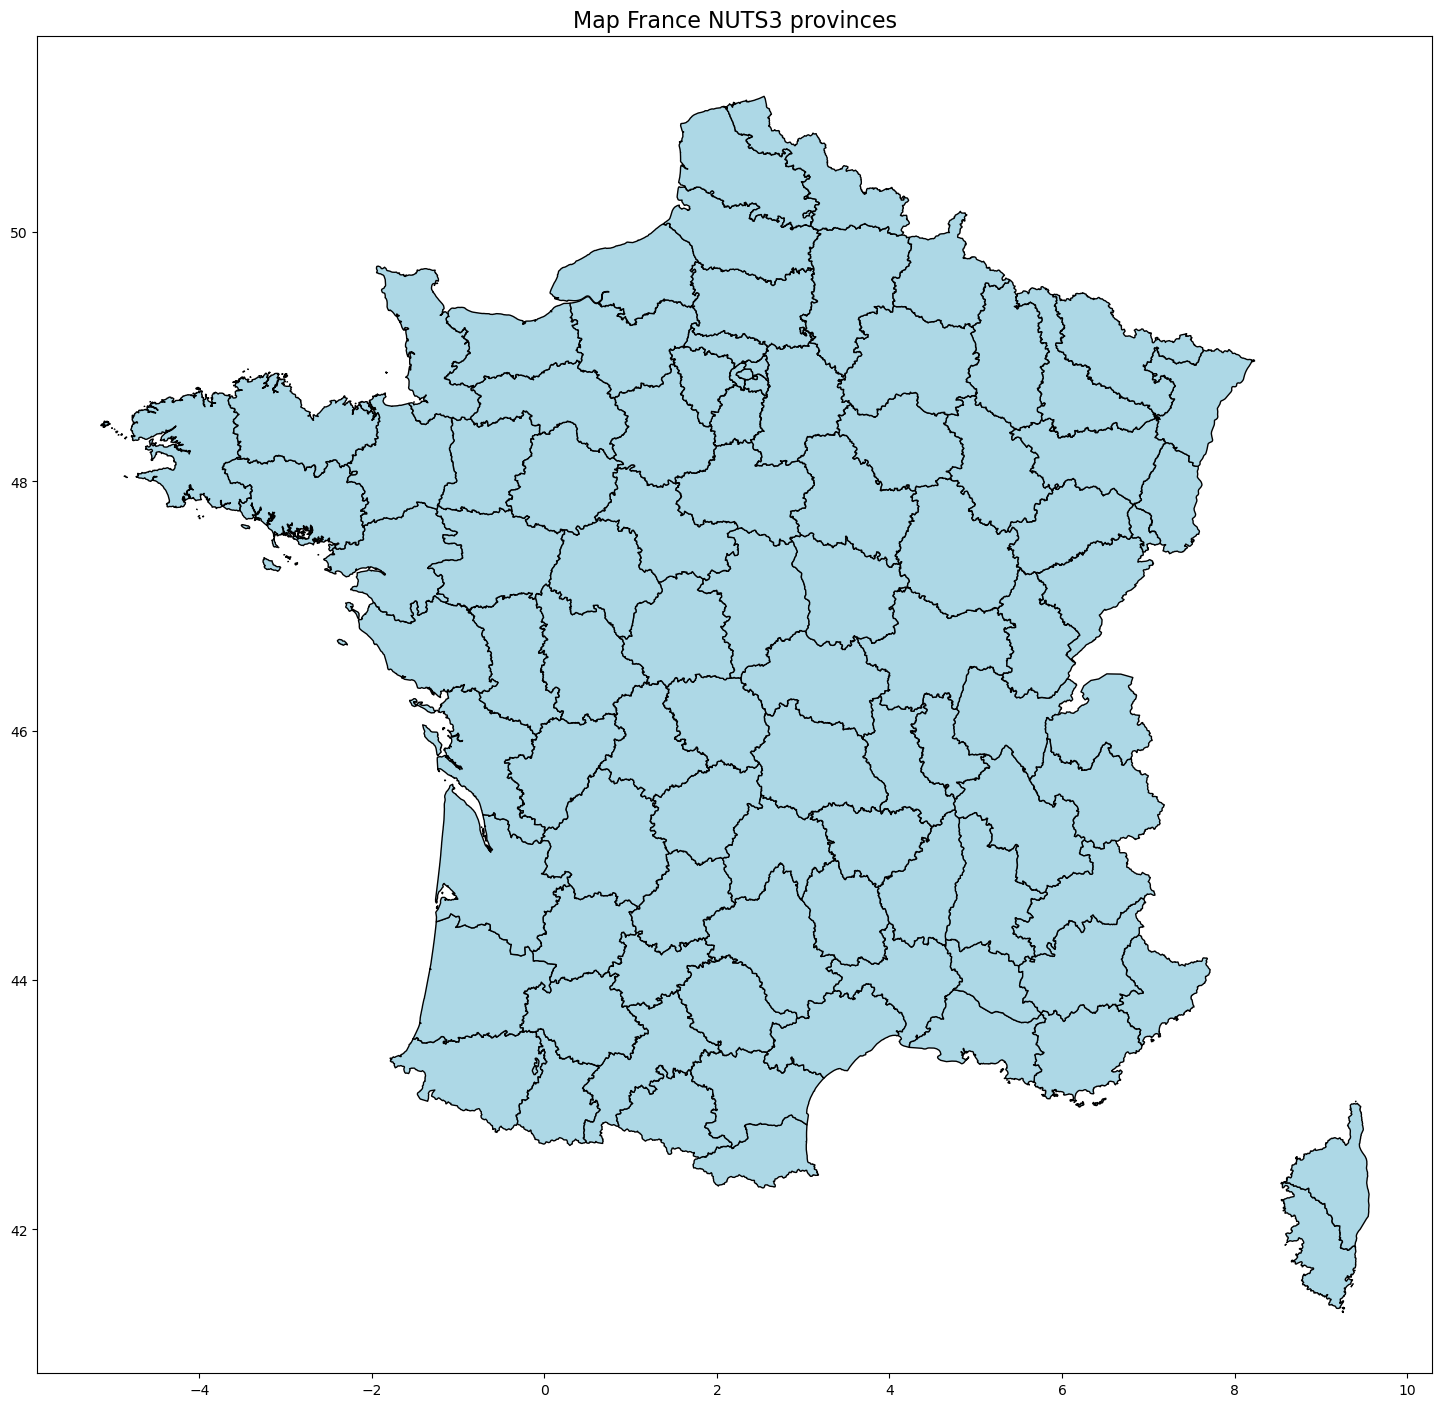

In [1088]:
# Plot France 
fig, ax = plt.subplots(figsize=(18, 18))
FR_eu_map.plot(ax=ax, color="lightblue", edgecolor="black")
ax.set_title("Map France NUTS3 provinces", fontsize=16) 
plt.show()

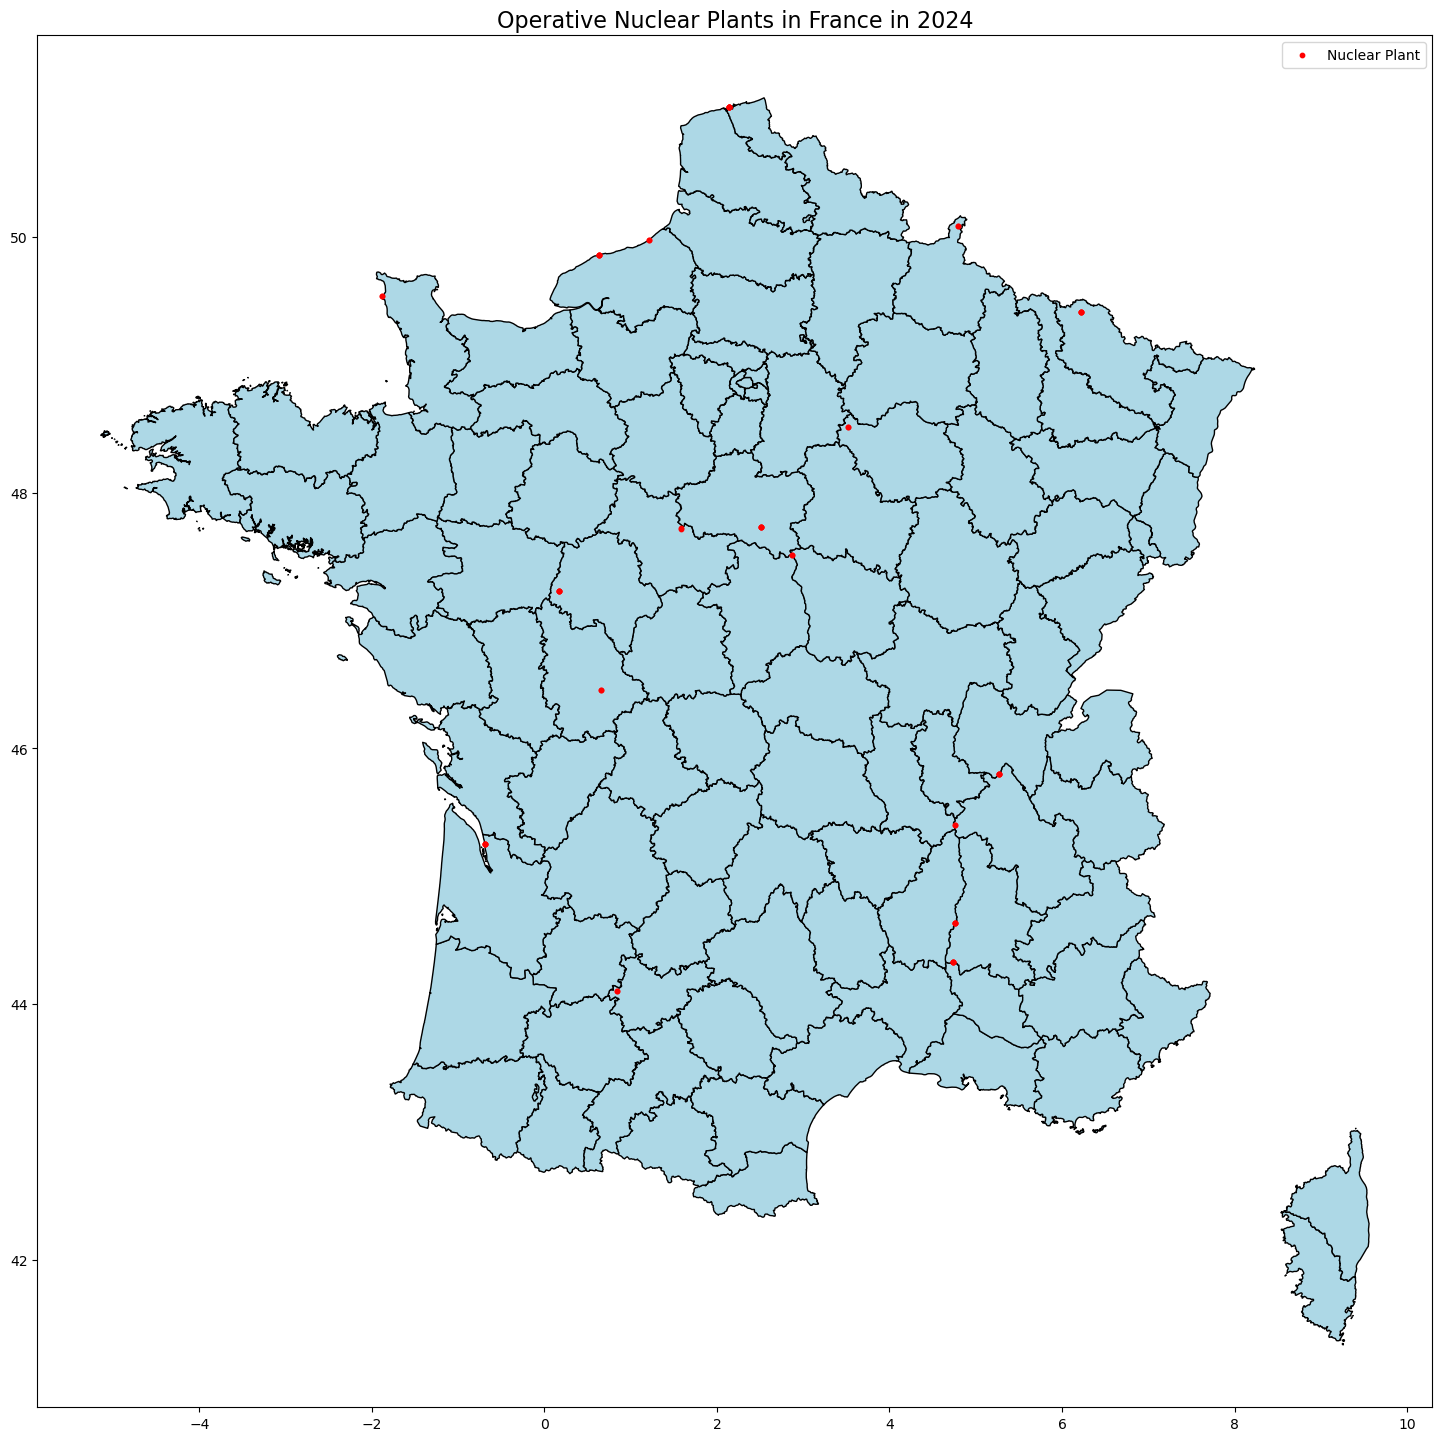

In [1089]:
fig, ax = plt.subplots(figsize=(18, 18))
FR_eu_map.plot(ax=ax, color="lightblue", edgecolor="black")
FR_plants.plot(ax=ax, color="red", markersize=10, label="Nuclear Plant")
ax.set_title("Operative Nuclear Plants in France in 2024", fontsize=16)
ax.legend()
plt.show()

In [1090]:
# Filter GDP data for France 
FR_merged_long = merged_long[merged_long['geo'].str[:2]=='FR']

print(FR_merged_long)

       NUTS_ID                                           geometry    geo  \
609      FR101  POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...  FR101   
610      FR102  POLYGON ((3.48685 48.84929, 3.48664 48.84594, ...  FR102   
611      FR103  POLYGON ((1.6143 49.07118, 1.62015 49.07392, 1...  FR103   
612      FR104  POLYGON ((2.32634 48.75058, 2.33075 48.7481, 2...  FR104   
613      FR105  POLYGON ((2.32906 48.81378, 2.32551 48.80953, ...  FR105   
...        ...                                                ...    ...   
168847   FRL04  MULTIPOLYGON (((5.77529 43.72224, 5.77714 43.7...  FRL04   
168848   FRL05  MULTIPOLYGON (((6.6378 43.78096, 6.64529 43.77...  FRL05   
168849   FRL06  MULTIPOLYGON (((4.66755 44.32365, 4.67408 44.3...  FRL06   
168850   FRM01  MULTIPOLYGON (((9.40072 41.85004, 9.4058 41.82...  FRM01   
168851   FRM02  MULTIPOLYGON (((9.38653 41.86696, 9.37524 41.8...  FRM02   

        year      GDP  
609     2001  74700.0  
610     2001  20200.0  
611     2001  3

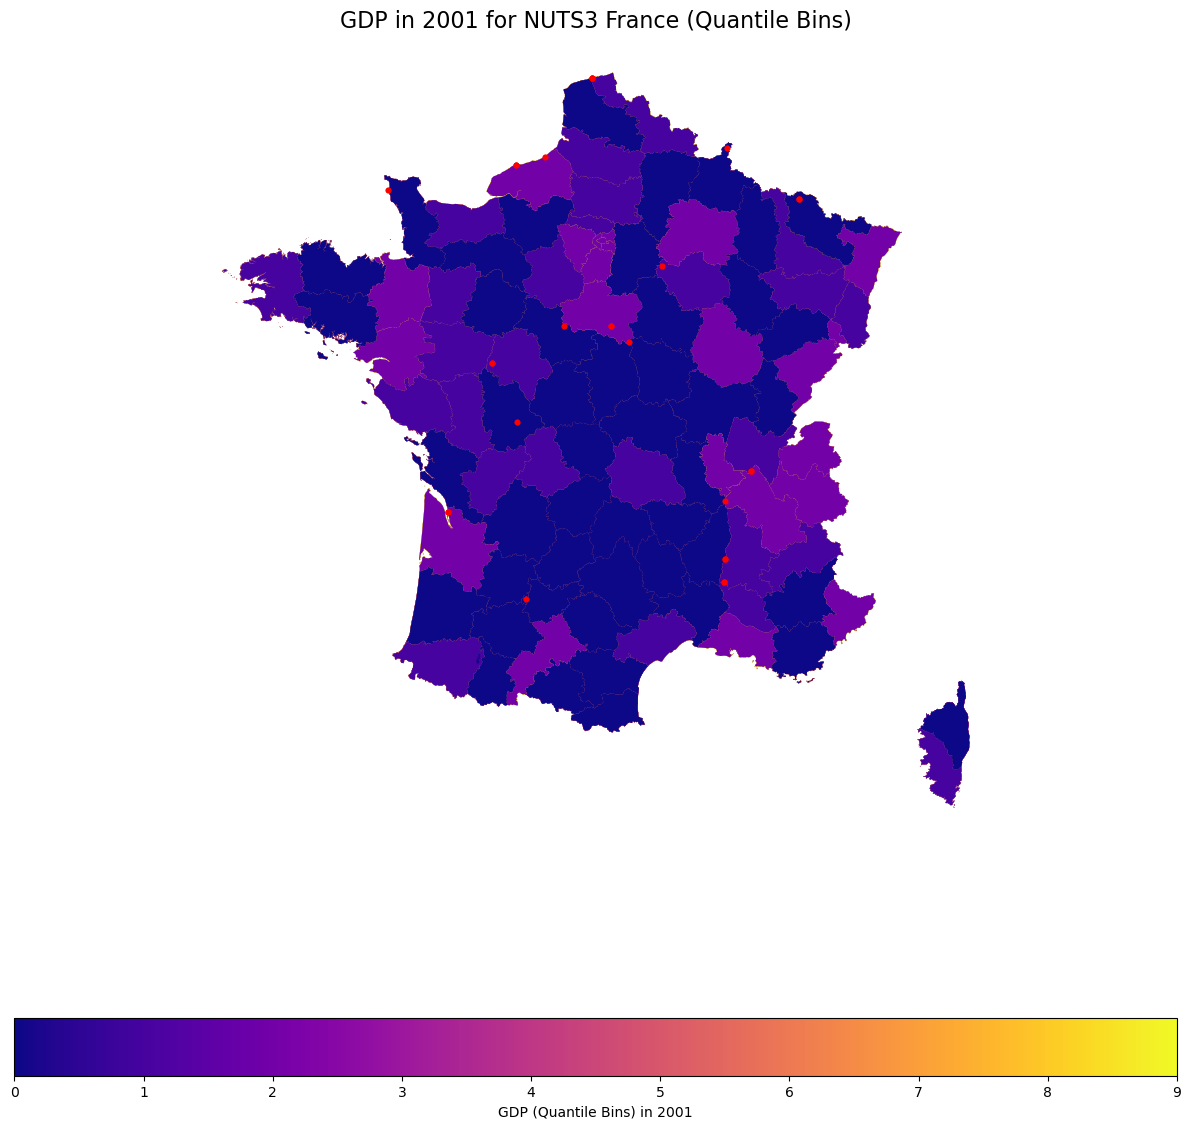

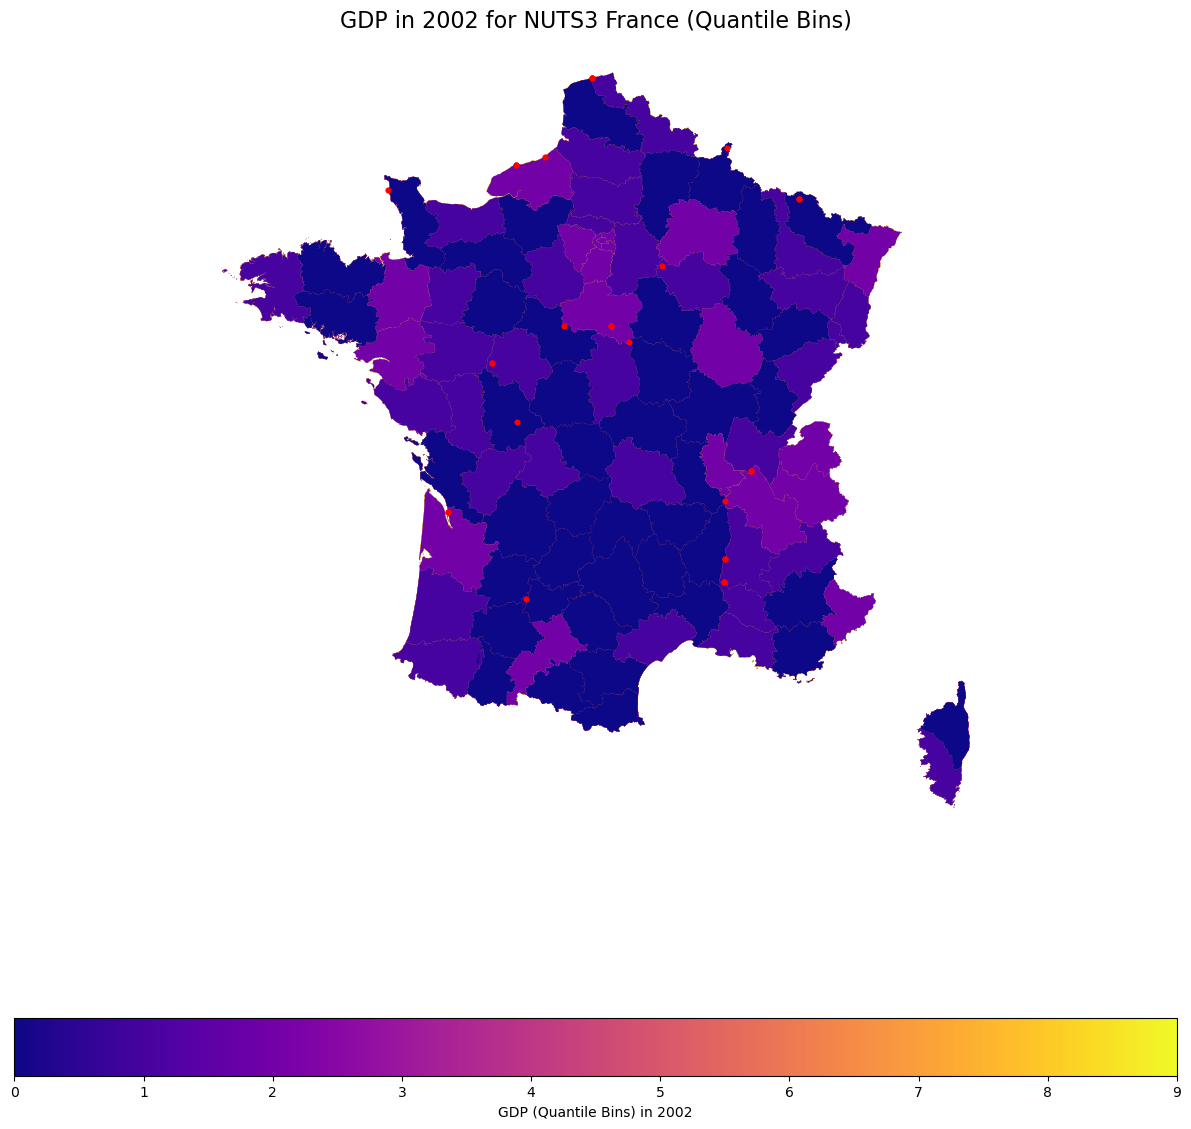

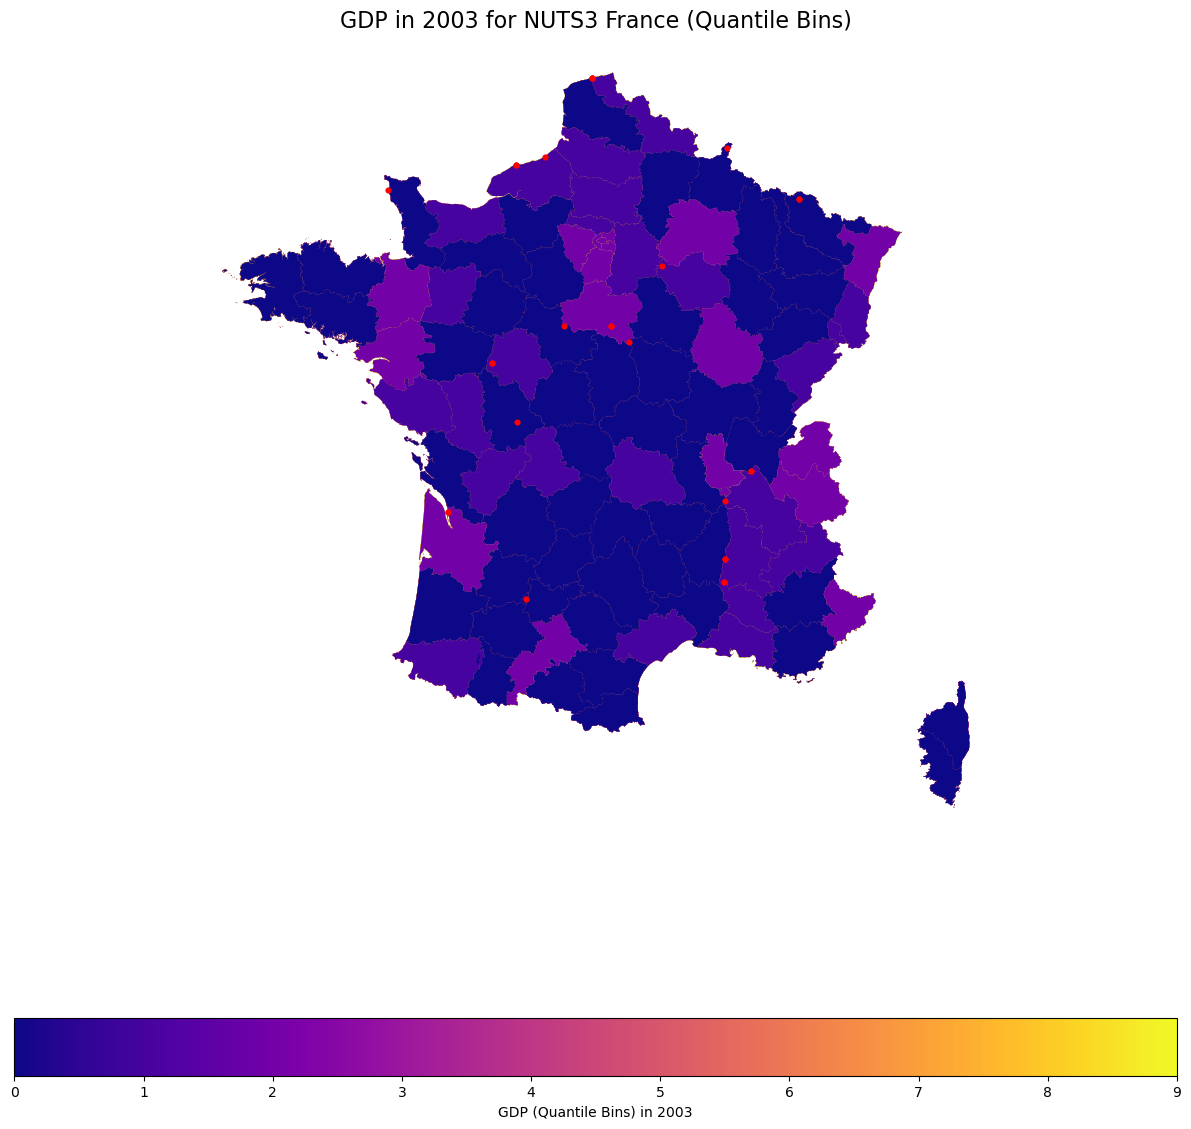

In [1091]:
# Filter for the years between 2001 and 2003
years_of_interest = range(2001, 2004)
FR_merged_long = FR_merged_long[FR_merged_long["year"].isin(years_of_interest)]

# Plot for each year
for year in years_of_interest:
    year_data = FR_merged_long[FR_merged_long["year"] == year].copy()  # Use .copy() to avoid SettingWithCopyWarning
    year_data.loc[:, "year"] = pd.to_numeric(year_data["year"], errors="coerce")  # Explicit .loc
    year_data["Scaled_GDP"] = (year_data["GDP"] - year_data["GDP"].min()) / (year_data["GDP"].max() - year_data["GDP"].min()) # Normalize GDP values to the range 0–1
    year_data["GDP_Bins"] = pd.qcut(year_data["GDP"], q=10, labels=False) # Add a new column with quantile bins
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    year_data.plot(
    column="GDP_Bins",
    cmap="plasma",
    legend=True,
    ax=ax,
    legend_kwds={
        "label": f"GDP (Quantile Bins) in {year}",
        "orientation": "horizontal"
    }
)
    FR_plants.plot(ax=ax, color="red", markersize=10, label="Nuclear Plant")
    ax.set_title(f"GDP in {year} for NUTS3 France (Quantile Bins)", fontsize=16)
    ax.axis("off")
    plt.savefig(f"GDP France {year}", bbox_inches="tight")
    plt.show()

#### **Czech Republic**
We conclude by plotting Czech Republic GDP by NUTS3 Regions

In [1093]:
# Filter for Czech Republic
CZ_plants = plants_gdf[plants_gdf['CountryCode']=='CZ']
CZ_eu_map = eu_map[eu_map['CNTR_CODE']=='CZ']

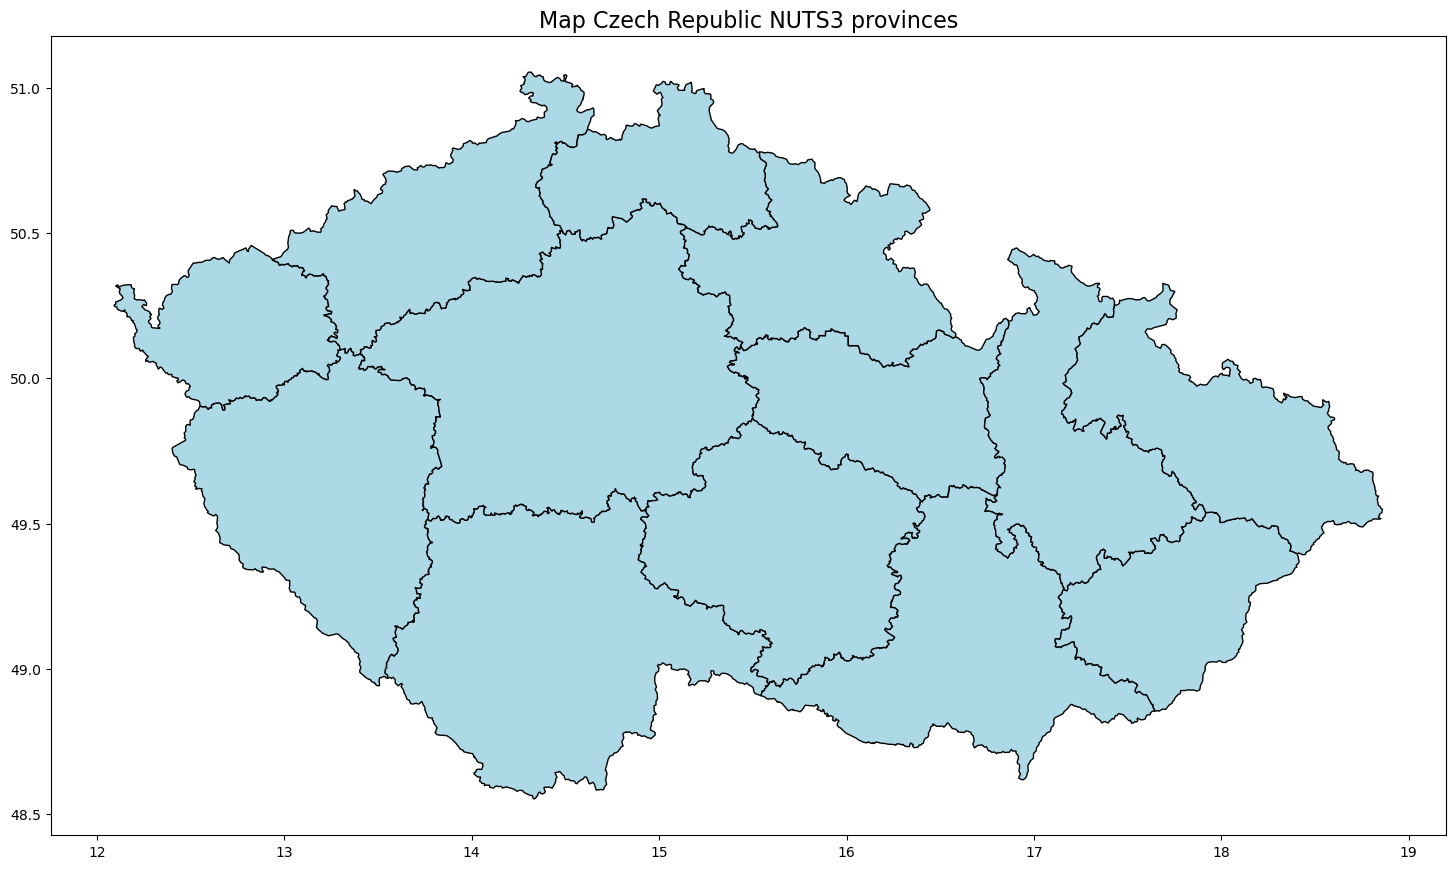

In [1094]:
fig, ax = plt.subplots(figsize=(18, 18))
CZ_eu_map.plot(ax=ax, color="lightblue", edgecolor="black")
ax.set_title("Map Czech Republic NUTS3 provinces", fontsize=16) 
plt.show()

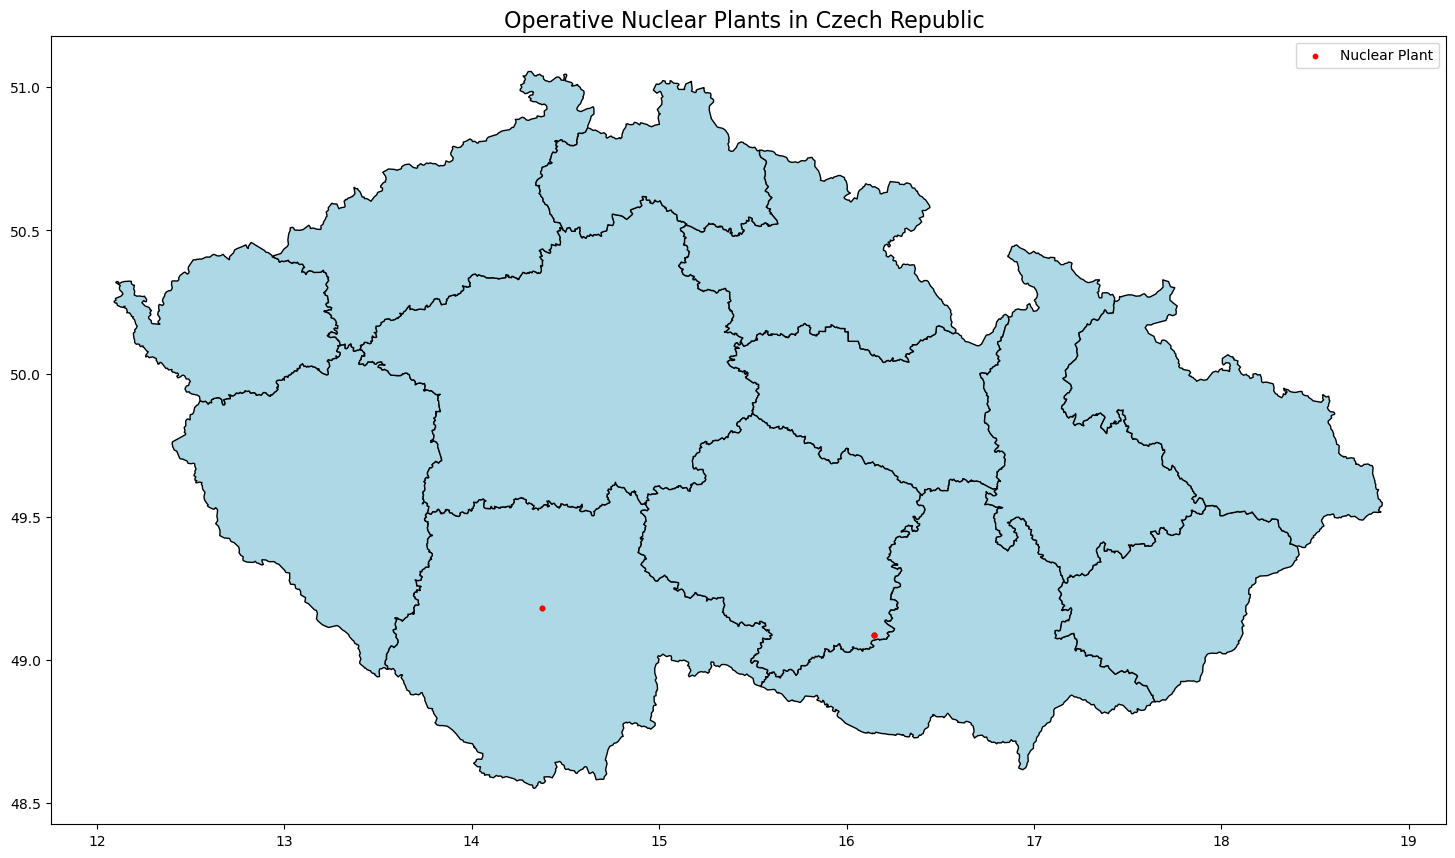

In [1095]:
fig, ax = plt.subplots(figsize=(18, 18))
CZ_eu_map.plot(ax=ax, color="lightblue", edgecolor="black")
CZ_plants.plot(ax=ax, color="red", markersize=10, label="Nuclear Plant")
ax.set_title("Operative Nuclear Plants in Czech Republic ", fontsize=16)
ax.legend()
plt.show()

In [1096]:
# Filter GDP data for Czech Republic
CZ_merged_long = merged_long[merged_long['geo'].str[:2]=='CZ']

print(CZ_merged_long)

       NUTS_ID                                           geometry    geo  \
107      CZ010  POLYGON ((14.52689 50.17744, 14.53198 50.17639...  CZ010   
108      CZ020  MULTIPOLYGON (((15.14161 50.52081, 15.13769 50...  CZ020   
109      CZ031  POLYGON ((14.92872 49.54218, 14.93827 49.53166...  CZ031   
110      CZ032  POLYGON ((13.40816 50.08122, 13.41516 50.08257...  CZ032   
111      CZ041  POLYGON ((12.95194 50.4034, 12.95822 50.40185,...  CZ041   
...        ...                                                ...    ...   
168263   CZ063  POLYGON ((16.38965 49.56192, 16.38542 49.55725...  CZ063   
168264   CZ064  POLYGON ((16.80274 49.59634, 16.78896 49.59065...  CZ064   
168265   CZ071  POLYGON ((16.92475 50.43938, 16.95087 50.43179...  CZ071   
168266   CZ072  POLYGON ((18.40838 49.38979, 18.41514 49.36826...  CZ072   
168267   CZ080  POLYGON ((18.05007 50.05874, 18.0612 50.05865,...  CZ080   

        year      GDP  
107     2001  15000.0  
108     2001   7300.0  
109     2001   

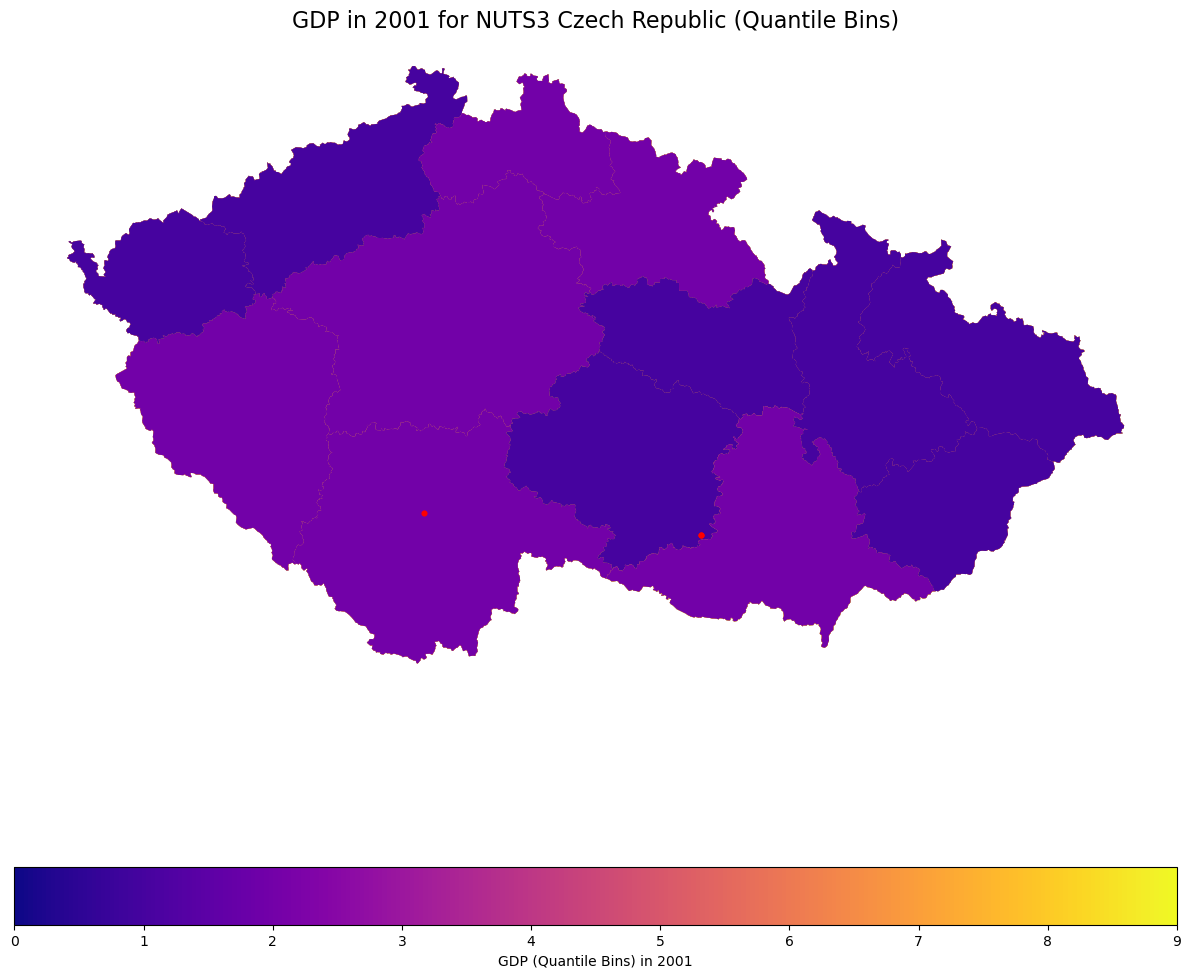

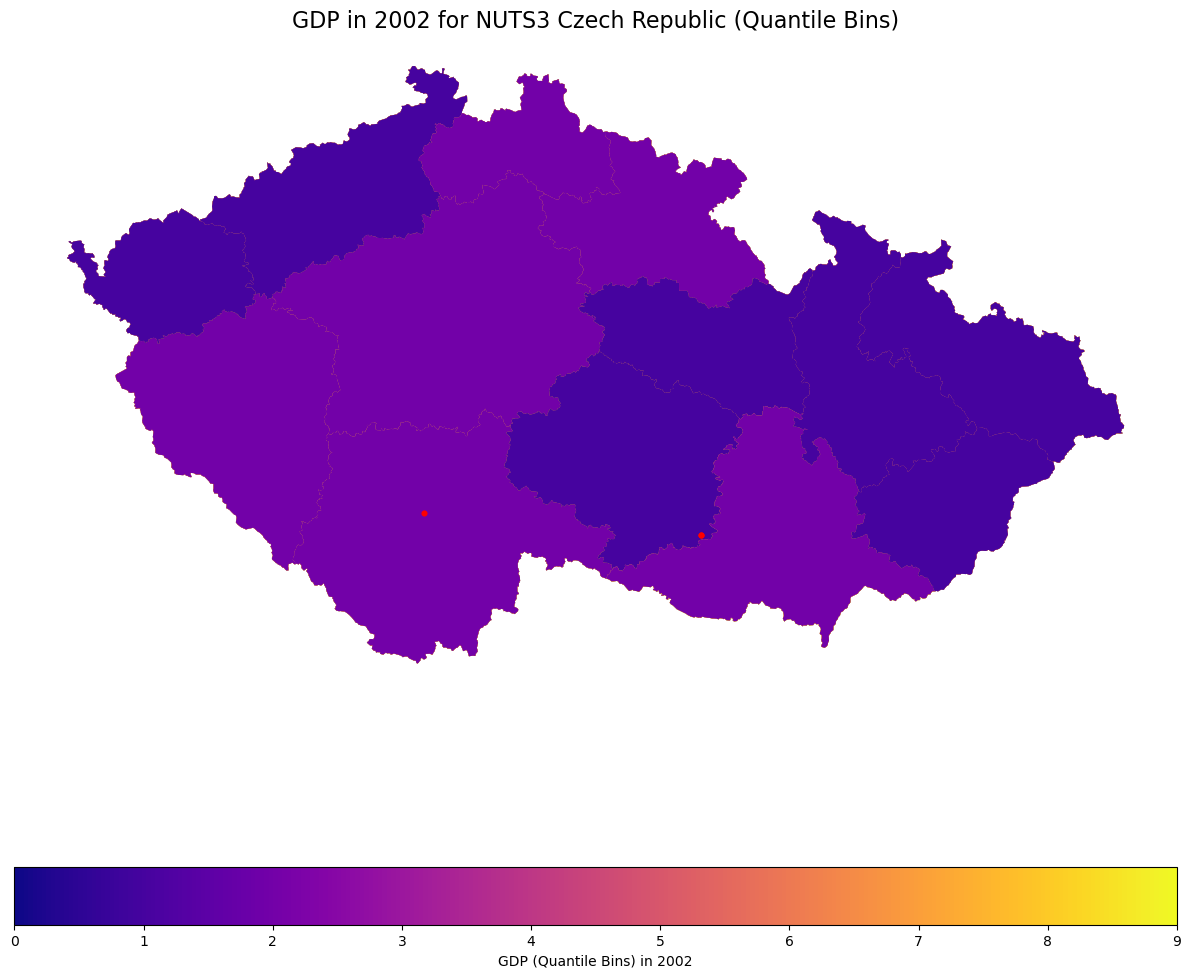

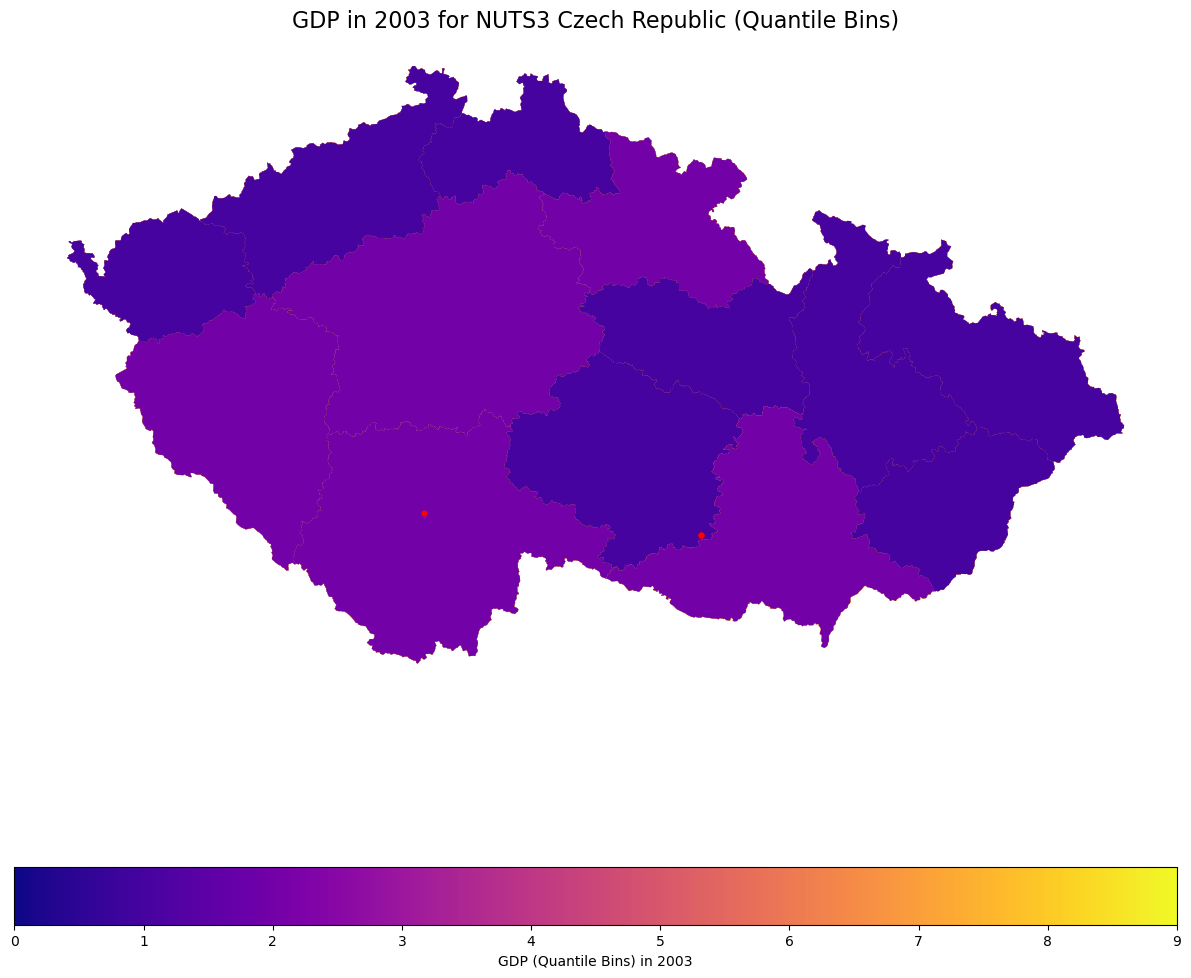

In [1097]:
# Filter for the years between 2001 and 2004
CZ_merged_long = CZ_merged_long[CZ_merged_long["year"].isin(years_of_interest)]

# Plot for each year
for year in years_of_interest:
    year_data = CZ_merged_long[CZ_merged_long["year"] == year].copy()  # Use .copy() to avoid SettingWithCopyWarning
    year_data.loc[:, "year"] = pd.to_numeric(year_data["year"], errors="coerce")  # Explicit .loc
    year_data["Scaled_GDP"] = (year_data["GDP"] - year_data["GDP"].min()) / (year_data["GDP"].max() - year_data["GDP"].min()) # Normalize GDP values to the range 0–1
    year_data["GDP_Bins"] = pd.qcut(year_data["GDP"], q=10, labels=False) # Add a new column with quantile bins
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    year_data.plot(
    column="GDP_Bins",
    cmap="plasma",
    legend=True,
    ax=ax,
    legend_kwds={
        "label": f"GDP (Quantile Bins) in {year}",
        "orientation": "horizontal"
    }
)
    CZ_plants.plot(ax=ax, color="red", markersize=10, label="Nuclear Plant")
    ax.set_title(f"GDP in {year} for NUTS3 Czech Republic (Quantile Bins)", fontsize=16)
    ax.axis("off")
    plt.savefig(f"GDP Czech Republic {year}", bbox_inches="tight")
    plt.show()

## **Regression Analysis** <br>
We now use FE method to analyse whether there is a correlation between the presence of Nuclear Plants and GDB in each NUTS3 region.
Our analysis will be based on two regression models:
- 1. \begin{equation}
        GDP_{i,t} = \alpha + \beta_1 Plant\_Operational_{i,t} + \beta_2 Employment\_Rate_{i,t} + a_{i} + \epsilon
     \end{equation}
- 2. \begin{equation}
        GDP_{i,t} = \alpha + \beta_1 Plant\_Operational_{i,t} + \beta_2 Employment\_Rate_{i,t} + \beta_3 Population\_Growth_{i,t} + a_{i} + \epsilon
     \end{equation}

where *$Plant\_Operational_{i,t}$* is a dummy variable which is equal to one if the Nuclear Reactor is operative in a particular NUTS3 Region and for a particular year; *$a_{i}$* are the fixed effects.

### **Dataset Preparation: Cleaning and Filtering for Regression Model 1**
The only nuclear reactors that become operative in the time period of analysis are located in France and Czech Rebuplic between the years 2001 and 2004, thus we filter the data merged_long for these two countries;

In [1100]:
years_of_interest = range(2001, 2004)

# Filter the observations for France and Czechia in the years between 2001 and 2004
RE_merged_long = merged_long[merged_long['geo'].str.startswith('FR', 'CZ')] # Filter for France and Czech Republic
RE_merged_long = RE_merged_long[RE_merged_long['year'].isin(years_of_interest)] # Filter for years 2001-2004
print(RE_merged_long)

      NUTS_ID                                           geometry    geo  year  \
609     FR101  POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...  FR101  2001   
610     FR102  POLYGON ((3.48685 48.84929, 3.48664 48.84594, ...  FR102  2001   
611     FR103  POLYGON ((1.6143 49.07118, 1.62015 49.07392, 1...  FR103  2001   
612     FR104  POLYGON ((2.32634 48.75058, 2.33075 48.7481, 2...  FR104  2001   
613     FR105  POLYGON ((2.32906 48.81378, 2.32551 48.80953, ...  FR105  2001   
...       ...                                                ...    ...   ...   
22680   FRL04  MULTIPOLYGON (((5.77529 43.72224, 5.77714 43.7...  FRL04  2003   
22681   FRL05  MULTIPOLYGON (((6.6378 43.78096, 6.64529 43.77...  FRL05  2003   
22682   FRL06  MULTIPOLYGON (((4.66755 44.32365, 4.67408 44.3...  FRL06  2003   
22683   FRM01  MULTIPOLYGON (((9.40072 41.85004, 9.4058 41.82...  FRM01  2003   
22684   FRM02  MULTIPOLYGON (((9.38653 41.86696, 9.37524 41.8...  FRM02  2003   

           GDP  
609    747

In [1101]:
# Create a function to check operational status
def is_operational(row, year):
    return (row['OperationalFrom'].year <= year) and (pd.isnull(row['OperationalTo']) or row['OperationalTo'].year >= year)

# Generalize: Create a binary variable for each year in the GDP dataset
years = range(2001, 2004)  # Adjust the range based on your GDP dataset
for year in years:
    plants_gdf[f'is_operational_{year}'] = plants_gdf.apply(lambda row: is_operational(row, year), axis=1)
 
print(plants_gdf.columns)

Index(['Id', 'Name', 'Latitude', 'Longitude', 'Country', 'CountryCode',
       'Status', 'ReactorType', 'ReactorModel', 'ConstructionStartAt',
       'OperationalFrom', 'OperationalTo', 'Capacity', 'LastUpdatedAt',
       'Source', 'IAEAId', 'geometry', 'is_operational_2001',
       'is_operational_2002', 'is_operational_2003'],
      dtype='object')


**nuclear_plants** dataset does not have NUTS3 region codes to locate them into the regions under analysis. Thus, we use the spatial join matching to infer in which region the nuclear plant is located:

In [1103]:
# Perform spatial join to map nuclear plants to NUTS3 regions
new_nuclear_plants = gpd.sjoin(plants_gdf, eu_map, how="left", predicate="within")

new_nuclear_plants.head()

Id          Name  Latitude  Longitude Country CountryCode       Status  \
10  11     Almaraz-1    39.807     -5.698   Spain          ES  Operational   
11  12     Almaraz-2    39.807     -5.698   Spain          ES  Operational   
21  22        Asco-1    41.202      0.571   Spain          ES  Operational   
22  23        Asco-2    41.202      0.571   Spain          ES  Operational   
43  44  Belleville-1    47.511      2.871  France          FR  Operational   

   ReactorType ReactorModel ConstructionStartAt  ... index_right NUTS_ID  \
10         PWR       WH 3LP          1973-07-03  ...       461.0   ES432   
11         PWR       WH 3LP          1973-07-03  ...       461.0   ES432   
21         PWR       WH 3LP          1974-05-16  ...       348.0   ES514   
22         PWR       WH 3LP          1975-03-07  ...       348.0   ES514   
43         PWR  P4 REP 1300          1980-05-01  ...       884.0   FRB01   

    LEVL_CODE CNTR_CODE  NAME_LATN  NUTS_NAME MOUNT_TYPE  URBN_TYPE  \
10        3.0        ES    Cáceres    Cáceres        4.0        2.0   
11        3.0        ES    Cáceres    Cáceres        4.0        2.0   
21        3.0        ES  Tarragona  Tarragona        2.0        2.0   
22        3.0        ES  Tarragona  Tarragona        2.0        2.0   
43        3.0        FR       Cher       Cher        4.0        3.0   

    COAST_TYPE    FID  
10         3.0  ES432  
11         3.0  ES432  
21         1.0  ES514  
22         1.0  ES514  
43         3.0  FRB01  

[5 rows x 30 columns]

In [1104]:
# Reshape the new_nuclear_plant data to long format for merging with merged_long
operational_long = new_nuclear_plants.melt(
    id_vars=['NUTS_ID'], 
    value_vars=[f'is_operational_{year}' for year in years],
    var_name='year',
    value_name='plant_operational'
)

# Extract the year (e.g., 2001, 2002) from the column names (is_operational_2001, etc.) and convert it to an integer
operational_long['year'] = operational_long['year'].str.extract(r'(\d+)').astype(int)

# Merge with the GDP dataset
RE_merged_long = pd.merge(RE_merged_long, operational_long, on=['NUTS_ID', 'year'], how='left')

# Fill missing values in the plant_operational column with 0 (no operative plant)
RE_merged_long['plant_operational'] = RE_merged_long['plant_operational'].fillna(0).astype(int)

RE_merged_long.head()

NUTS_ID                                           geometry    geo  year  \
0   FR101  POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...  FR101  2001   
1   FR102  POLYGON ((3.48685 48.84929, 3.48664 48.84594, ...  FR102  2001   
2   FR103  POLYGON ((1.6143 49.07118, 1.62015 49.07392, 1...  FR103  2001   
3   FR104  POLYGON ((2.32634 48.75058, 2.33075 48.7481, 2...  FR104  2001   
4   FR105  POLYGON ((2.32906 48.81378, 2.32551 48.80953, ...  FR105  2001   

       GDP  plant_operational  
0  74700.0                  0  
1  20200.0                  0  
2  30000.0                  0  
3  27600.0                  0  
4  67900.0                  0

In [1105]:
print(RE_merged_long.dtypes)

NUTS_ID                object
geometry             geometry
geo                    object
year                    int32
GDP                   float64
plant_operational       int32
dtype: object


In [1106]:
RE_merged_long.drop('NUTS_ID', axis=1, inplace=True)

We now load population and employment datasets. These datasets will be used to find employment rates, which is not available in the Eurostats database.

In [1108]:
# Load population by NUTS3 
pop = pd.read_csv("estat_demo_r_pjanaggr3.tsv.gz", sep="\t", compression="gzip")

# Load employment by NUTS3 
emp = pd.read_csv("estat_nama_10r_3empers.tsv.gz", sep="\t", compression="gzip")

print(pop.columns)
print(emp.columns)
pop.head()

Index(['freq,unit,sex,age,geo\TIME_PERIOD', '1990 ', '1991 ', '1992 ', '1993 ',
       '1994 ', '1995 ', '1996 ', '1997 ', '1998 ', '1999 ', '2000 ', '2001 ',
       '2002 ', '2003 ', '2004 ', '2005 ', '2006 ', '2007 ', '2008 ', '2009 ',
       '2010 ', '2011 ', '2012 ', '2013 ', '2014 ', '2015 ', '2016 ', '2017 ',
       '2018 ', '2019 ', '2020 ', '2021 ', '2022 ', '2023 '],
      dtype='object')
Index(['freq,unit,wstatus,nace_r2,geo\TIME_PERIOD', '1995 ', '1996 ', '1997 ',
       '1998 ', '1999 ', '2000 ', '2001 ', '2002 ', '2003 ', '2004 ', '2005 ',
       '2006 ', '2007 ', '2008 ', '2009 ', '2010 ', '2011 ', '2012 ', '2013 ',
       '2014 ', '2015 ', '2016 ', '2017 ', '2018 ', '2019 ', '2020 ', '2021 ',
       '2022 '],
      dtype='object')


freq,unit,sex,age,geo\TIME_PERIOD 1990  1991  1992  1993  1994  1995  1996   \
0                   A,NR,F,TOTAL,AL    :     :     :     :     :     :     :    
1                  A,NR,F,TOTAL,AL0    :     :     :     :     :     :     :    
2                 A,NR,F,TOTAL,AL01    :     :     :     :     :     :     :    
3                A,NR,F,TOTAL,AL011    :     :     :     :     :     :     :    
4                A,NR,F,TOTAL,AL012    :     :     :     :     :     :     :    

  1997  1998   ...     2014      2015      2016      2017      2018   \
0    :     :   ...  1430827   1424597   1417141   1423050   1431715    
1    :     :   ...  1430827   1424597   1417141   1423050   1431715    
2    :     :   ...   416084    410586    406682    405835    405598    
3    :     :   ...    64941     63084     61749     59837     57895    
4    :     :   ...   135390    135847    136589    139433    142648    

      2019      2020      2021      2022      2023   
0  1432833   1425342   1419759   1406532   1394864   
1  1432833   1425342   1419759   1406532   1394864   
2   404201    399599    396799    390886    385462   
3    57002     55402     54311     52440     51030   
4   143366    143561    144381    144229    143757   

[5 rows x 35 columns]

In [1109]:
emp.head()

freq,unit,wstatus,nace_r2,geo\TIME_PERIOD 1995  1996  1997  1998  1999   \
0                            A,THS,EMP,A,AT    :     :     :     :     :    
1                           A,THS,EMP,A,AT1    :     :     :     :     :    
2                          A,THS,EMP,A,AT11    :     :     :     :     :    
3                         A,THS,EMP,A,AT111    :     :     :     :     :    
4                         A,THS,EMP,A,AT112    :     :     :     :     :    

    2000    2001    2002    2003   ...   2013    2014    2015    2016   \
0  231.8   230.6   226.5   225.9   ...  182.6   188.5   176.6   171.9    
1     71    70.1    68.6      68   ...     54    55.8    52.7    51.6    
2   13.1    12.9    12.4    12.2   ...    8.3     8.6     8.2     7.9    
3    1.8     1.7     1.6     1.6   ...    0.9     0.9     0.9     0.8    
4    6.2     6.1       6     5.9   ...    4.4     4.7     4.7     4.6    

    2017    2018    2019    2020    2021  2022   
0  167.7   157.1   149.4   152.3   156.5     :   
1   50.7    47.5    45.5    45.6    46.7     :   
2    7.9     7.4     7.2     7.3     7.6     :   
3    0.8     0.8     0.8     0.8     0.8     :   
4    4.6     4.4     4.3     4.4     4.6     :   

[5 rows x 29 columns]

We procced my preparing the datasets for the regression. Note, the procedure is almost identical to the one followed for the merged_long data. The reason is that they are all Eurostats data. Thus:

In [1111]:
# Split the combined column into separate columns
pop_split = pop['freq,unit,sex,age,geo\\TIME_PERIOD'].str.split(',', expand=True)
emp_split = emp['freq,unit,wstatus,nace_r2,geo\\TIME_PERIOD'].str.split(',', expand=True)

# Assign meaningful names to the new columns
pop_split.columns = ['freq', 'unit', "sex", "age", 'geo']
emp_split.columns = ['freq', 'unit', 'wstatus', 'nace_r2', 'geo']

# Merge the split columns back into the original DataFrame
pop = pd.concat([pop, pop_split], axis=1)
emp = pd.concat([emp, emp_split], axis=1)

# Drop the original combined column (optional)
pop.drop(columns=['freq,unit,sex,age,geo\\TIME_PERIOD'], inplace=True)
emp.drop(columns=['freq,unit,wstatus,nace_r2,geo\\TIME_PERIOD'], inplace=True)

# Step 1: Filter 'gdp' to keep only relevant rows
pop = pop[pop['geo'].isin(eu_map['NUTS_ID'])]
emp = emp[emp['geo'].isin(eu_map['NUTS_ID'])]

# Strip leading/trailing spaces from all column names
pop.columns = pop.columns.str.strip()
emp.columns = emp.columns.str.strip()
print(pop.columns)
print(emp.columns)

Index(['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998',
       '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '2019', '2020', '2021', '2022', '2023', 'freq', 'unit',
       'sex', 'age', 'geo'],
      dtype='object')
Index(['1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003',
       '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021',
       '2022', 'freq', 'unit', 'wstatus', 'nace_r2', 'geo'],
      dtype='object')


In [1112]:
years = ["2001", "2002","2003","2004","2005","2006","2007","2008","2009","2010","2011","2012","2013","2014","2015",
        "2016", "2017", "2018","2019","2020","2021","2022"]
for year in years:
    pop[year] = pop[year].astype(str).str.strip()
    pop[year] = pop[year].str.replace(r"[^\d.]", "", regex=True)
    pop[year] = pd.to_numeric(pop[year], errors="coerce").fillna(0)


In [1113]:
# Reshape the population data to long format for merging
operational_long2 = pop.melt(
    id_vars='geo', 
    value_vars=years,
    var_name='year',
    value_name='population'
)

# Convert the 'year' column to integers 
operational_long2['year'] = operational_long2['year'].astype(int)

# Merge with the merg_long dataset
RE_merged_long = pd.merge(RE_merged_long, operational_long2, on=['geo', 'year'], how='left')

In [1114]:
print(RE_merged_long.head())

                                            geometry    geo  year      GDP  \
0  POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...  FR101  2001  74700.0   
1  POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...  FR101  2001  74700.0   
2  POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...  FR101  2001  74700.0   
3  POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...  FR101  2001  74700.0   
4  POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...  FR101  2001  74700.0   

   plant_operational  population  
0                  0   1133465.0  
1                  0         0.0  
2                  0    788179.0  
3                  0    195374.0  
4                  0    149912.0  


In [1115]:
for year in years:
    emp[year] = emp[year].astype(str).str.strip()
    emp[year] = emp[year].str.replace(r"[^\d.]", "", regex=True)
    emp[year] = pd.to_numeric(emp[year], errors="coerce").fillna(0)

In [1116]:
# Reshape the employment data to long format for merging
operational_long3 = emp.melt(
    id_vars=['geo'],  
    value_vars=years,
    var_name='year',
    value_name='employment'
)

# Convert the 'year' column to integers 
operational_long3['year'] = operational_long3['year'].astype(int)

# Merge with the GDP dataset
RE_merged_long = pd.merge(RE_merged_long, operational_long3, on=['geo', 'year'], how='left')

In [1117]:
print(RE_merged_long.head())

                                            geometry    geo  year      GDP  \
0  POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...  FR101  2001  74700.0   
1  POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...  FR101  2001  74700.0   
2  POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...  FR101  2001  74700.0   
3  POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...  FR101  2001  74700.0   
4  POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...  FR101  2001  74700.0   

   plant_operational  population  employment  
0                  0   1133465.0        1.60  
1                  0   1133465.0       85.28  
2                  0   1133465.0       67.45  
3                  0   1133465.0       34.62  
4                  0   1133465.0      440.83  


We now compute the employment rate:
\begin{equation}
employment\_rate_{i,t} = \frac{employment_{i,t}}{population_{i,t}}
\end{equation}

In [1119]:
# Compute the employment rate given employment and population
RE_merged_long['employment'] = RE_merged_long['employment'] * 1000
RE_merged_long['employment_rate'] = (RE_merged_long['employment'] / RE_merged_long['population']) * 100
RE_merged_long['employment_rate'] = RE_merged_long['employment_rate'].fillna(0).replace([np.inf, -np.inf], 0)
print(RE_merged_long)

                                                  geometry    geo  year  \
0        POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...  FR101  2001   
1        POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...  FR101  2001   
2        POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...  FR101  2001   
3        POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...  FR101  2001   
4        POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...  FR101  2001   
...                                                    ...    ...   ...   
1275745  MULTIPOLYGON (((9.38653 41.86696, 9.37524 41.8...  FRM02  2003   
1275746  MULTIPOLYGON (((9.38653 41.86696, 9.37524 41.8...  FRM02  2003   
1275747  MULTIPOLYGON (((9.38653 41.86696, 9.37524 41.8...  FRM02  2003   
1275748  MULTIPOLYGON (((9.38653 41.86696, 9.37524 41.8...  FRM02  2003   
1275749  MULTIPOLYGON (((9.38653 41.86696, 9.37524 41.8...  FRM02  2003   

             GDP  plant_operational  population  employment  employment_rate  
0        74700.0    

Check whether the computed employment rate is out of the range 0-100:

In [1121]:
# Check if all values are between 0 and 100
is_within_range = (RE_merged_long['employment_rate'] >= 0) & (RE_merged_long['employment_rate'] <= 100)

# Verify if all values satisfy the condition
all_within_range = is_within_range.all()

# Output the result
if all_within_range:
    print("All values in the 'employment_rate' column are between 0 and 100.")
else:
    print("Some values in the 'employment_rate' column are outside the range 0-100.")
    # Optionally display the rows with out-of-range values
    print(RE_merged_long[~is_within_range])


Some values in the 'employment_rate' column are outside the range 0-100.
                                                  geometry    geo  year  \
14       POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...  FR101  2001   
29       POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...  FR101  2001   
74       POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...  FR101  2001   
89       POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...  FR101  2001   
94       POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...  FR101  2001   
...                                                    ...    ...   ...   
1275599  MULTIPOLYGON (((9.38653 41.86696, 9.37524 41.8...  FRM02  2003   
1275704  MULTIPOLYGON (((9.38653 41.86696, 9.37524 41.8...  FRM02  2003   
1275719  MULTIPOLYGON (((9.38653 41.86696, 9.37524 41.8...  FRM02  2003   
1275734  MULTIPOLYGON (((9.38653 41.86696, 9.37524 41.8...  FRM02  2003   
1275749  MULTIPOLYGON (((9.38653 41.86696, 9.37524 41.8...  FRM02  2003   

             GDP  plant_op

Drop observations for which the employment rate is out of the range 0-100

In [1123]:
# Filter rows where employment_rate is between 0 and 100
RE_merged_long = RE_merged_long[(RE_merged_long['employment_rate'] >= 0) & (RE_merged_long['employment_rate'] <= 100)]

# Reset the index after filtering (optional)
RE_merged_long.reset_index(drop=True, inplace=True)

# Verify the filtering
print("Filtered dataset:")
print(RE_merged_long)

Filtered dataset:
                                                  geometry    geo  year  \
0        POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...  FR101  2001   
1        POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...  FR101  2001   
2        POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...  FR101  2001   
3        POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...  FR101  2001   
4        POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...  FR101  2001   
...                                                    ...    ...   ...   
1158698  MULTIPOLYGON (((9.38653 41.86696, 9.37524 41.8...  FRM02  2003   
1158699  MULTIPOLYGON (((9.38653 41.86696, 9.37524 41.8...  FRM02  2003   
1158700  MULTIPOLYGON (((9.38653 41.86696, 9.37524 41.8...  FRM02  2003   
1158701  MULTIPOLYGON (((9.38653 41.86696, 9.37524 41.8...  FRM02  2003   
1158702  MULTIPOLYGON (((9.38653 41.86696, 9.37524 41.8...  FRM02  2003   

             GDP  plant_operational  population  employment  employment_rate  
0 

Assume 1 year lagged gdp

The final dataset used for the FE regression is:

In [1126]:
# Check for missing values
print(RE_merged_long.isnull().sum())
print(RE_merged_long.columns)

geometry             0
geo                  0
year                 0
GDP                  0
plant_operational    0
population           0
employment           0
employment_rate      0
dtype: int64
Index(['geometry', 'geo', 'year', 'GDP', 'plant_operational', 'population',
       'employment', 'employment_rate'],
      dtype='object')


#### **Regression Model 1**
We now run the **Fixed Effects Regression Model 1**

In [1128]:
#Ensure the dataset is indexed by region and year
RE_merged_long = RE_merged_long.set_index(['geo', 'year'])

# Define the dependent variable (GDP) and independent variables
dependent = RE_merged_long['GDP']
independent_vars = RE_merged_long[['plant_operational', 'employment_rate']]

# Add a constant term (optional, depends on the model setup)
independent_vars = sm.add_constant(independent_vars)

# Define the model
model1 = PanelOLS(dependent, independent_vars, entity_effects=True)

In [1209]:
# Fit the model
results1 = model1.fit(cov_type='robust')

# Display the summary of results
print(results.summary)

# Save the regression summary to a LaTeX file
with open('regression_results1.tex', 'w') as file:
    file.write(results1.summary.as_latex())

                          PanelOLS Estimation Summary                           
Dep. Variable:                    GDP   R-squared:                     3.611e-06
Estimator:                   PanelOLS   R-squared (Between):             -0.0013
No. Observations:             1158703   R-squared (Within):            3.611e-06
Date:                Mon, Jan 20 2025   R-squared (Overall):              0.0013
Time:                        11:15:20   Log-likelihood                -1.252e+07
Cov. Estimator:                Robust                                           
                                        F-statistic:                      2.0920
Entities:                          96   P-value                           0.1234
Avg Obs:                    1.207e+04   Distribution:               F(2,1158605)
Min Obs:                       7238.0                                           
Max Obs:                     5.12e+04   F-statistic (robust):             5.3099
                            

### **Dataset Preparation: Filtering for Regression Model 2**
We now compute the *$Employment\_Rate_{i,t}$* by using the **working population** instead of all **population**. Moreover, we add to the model the *$Population\_Growth_{i,t}$* variable.

In [1131]:
# Drop population and employment rate 
RE_merged_long.drop(['population', 'employment_rate'], axis=1, inplace=True)

In [1132]:
# Load population by NUTS3 
working_pop = pd.read_csv("estat_demo_r_pjanaggr3_filtered.tsv.gz", sep="\t", compression="gzip")

# Load population growth by NUTS3 
pop_growth = pd.read_csv("estat_demo_r_gind3_filtered.tsv.gz", sep="\t", compression="gzip")

print(pop_growth.columns)
print(working_pop.columns)

Index(['freq,indic_de,geo\TIME_PERIOD', '2000 ', '2001 ', '2002 ', '2003 ',
       '2004 ', '2005 ', '2006 ', '2007 ', '2008 ', '2009 ', '2010 ', '2011 ',
       '2012 ', '2013 ', '2014 ', '2015 ', '2016 ', '2017 ', '2018 ', '2019 ',
       '2020 ', '2021 ', '2022 ', '2023 '],
      dtype='object')
Index(['freq,unit,sex,age,geo\TIME_PERIOD', '2000 ', '2001 ', '2002 ', '2003 ',
       '2004 ', '2005 ', '2006 ', '2007 ', '2008 ', '2009 ', '2010 ', '2011 ',
       '2012 ', '2013 ', '2014 ', '2015 ', '2016 ', '2017 ', '2018 ', '2019 ',
       '2020 ', '2021 ', '2022 ', '2023 '],
      dtype='object')


In [1133]:
# Split the combined column into separate columns
working_pop_split =working_pop ['freq,unit,sex,age,geo\\TIME_PERIOD'].str.split(',', expand=True)
pop_growth_split = pop_growth ['freq,indic_de,geo\\TIME_PERIOD'].str.split(',', expand=True)

# Assign meaningful names to the new columns
working_pop_split.columns = ['freq', 'unit', "sex", "age", 'geo']
pop_growth_split.columns = ['freq', 'indic_de', 'geo']

# Merge the split columns back into the original DataFrame
working_pop  = pd.concat([working_pop , working_pop_split], axis=1)
pop_growth  = pd.concat([pop_growth , pop_growth_split], axis=1)

# Drop the original combined column (optional)
working_pop .drop(columns=['freq,unit,sex,age,geo\\TIME_PERIOD'], inplace=True)
pop_growth .drop(columns=['freq,indic_de,geo\\TIME_PERIOD'], inplace=True)

# Step 1: Filter 'gdp' to keep only relevant rows
working_pop = working_pop [working_pop ['geo'].isin(eu_map['NUTS_ID'])]
pop_growth = pop_growth [pop_growth ['geo'].isin(eu_map['NUTS_ID'])]

# Strip leading/trailing spaces from all column names
working_pop.columns = working_pop.columns.str.strip()
pop_growth.columns = pop_growth.columns.str.strip()

In [1134]:
years = ["2001", "2002","2003","2004","2005","2006","2007","2008","2009","2010","2011","2012","2013","2014","2015",
        "2016", "2017", "2018","2019","2020","2021","2022"]
for year in years:
    working_pop[year] = working_pop[year].astype(str).str.strip()
    working_pop[year] = working_pop[year].str.replace(r"[^\d.]", "", regex=True)
    working_pop[year] = pd.to_numeric(working_pop[year], errors="coerce").fillna(0)


In [1135]:
# Reshape the employment data to long format for merging
operational_long4 = working_pop.melt(
    id_vars=['geo'],  
    value_vars=years,
    var_name='year',
    value_name='working population'
)

# Convert the 'year' column to integers 
operational_long4['year'] = operational_long4['year'].astype(int)

# Merge with the GDP dataset
RE_merged_long = pd.merge(RE_merged_long, operational_long4, on=['geo', 'year'], how='left')

In [1136]:
for year in years:
    pop_growth[year] = pop_growth[year].astype(str).str.strip()
    pop_growth[year] = pop_growth[year].str.replace(r"[^\d.]", "", regex=True)
    pop_growth[year] = pd.to_numeric(pop_growth[year], errors="coerce").fillna(0)

In [1137]:
# Reshape the employment data to long format for merging
operational_long5 = pop_growth.melt(
    id_vars=['geo'],  
    value_vars=years,
    var_name='year',
    value_name='population growth'
)

# Convert the 'year' column to integers 
operational_long5['year'] = operational_long5['year'].astype(int)

# Merge with the GDP dataset
RE_merged_long = pd.merge(RE_merged_long, operational_long5, on=['geo', 'year'], how='left')

In [1138]:
print(RE_merged_long.dtypes)

geo                     object
year                     int32
geometry              geometry
GDP                    float64
plant_operational        int32
employment             float64
working population     float64
population growth      float64
dtype: object


In [1139]:
# Compute the employment rate given employment and population
RE_merged_long['employment_rate'] = (RE_merged_long['employment'] / RE_merged_long['working population']) * 100
RE_merged_long['employment_rate'] = RE_merged_long['employment_rate'].fillna(0).replace([np.inf, -np.inf], 0)
print(RE_merged_long)

           geo  year                                           geometry  \
0        FR101  2001  POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...   
1        FR101  2001  POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...   
2        FR101  2001  POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...   
3        FR101  2001  POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...   
4        FR101  2001  POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...   
...        ...   ...                                                ...   
3476104  FRM02  2003  MULTIPOLYGON (((9.38653 41.86696, 9.37524 41.8...   
3476105  FRM02  2003  MULTIPOLYGON (((9.38653 41.86696, 9.37524 41.8...   
3476106  FRM02  2003  MULTIPOLYGON (((9.38653 41.86696, 9.37524 41.8...   
3476107  FRM02  2003  MULTIPOLYGON (((9.38653 41.86696, 9.37524 41.8...   
3476108  FRM02  2003  MULTIPOLYGON (((9.38653 41.86696, 9.37524 41.8...   

             GDP  plant_operational  employment  working population  \
0        74700.0            

In [1140]:
# Check if all values are between 0 and 100
is_within_range = (RE_merged_long['employment_rate'] >= 0) & (RE_merged_long['employment_rate'] <= 100)

# Verify if all values satisfy the condition
all_within_range = is_within_range.all()

# Output the result
if all_within_range:
    print("All values in the 'employment_rate' column are between 0 and 100.")
else:
    print("Some values in the 'employment_rate' column are outside the range 0-100.")
    # Optionally display the rows with out-of-range values
    print(RE_merged_long[~is_within_range])


Some values in the 'employment_rate' column are outside the range 0-100.
           geo  year                                           geometry  \
126      FR101  2001  POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...   
127      FR101  2001  POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...   
128      FR101  2001  POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...   
171      FR101  2001  POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...   
172      FR101  2001  POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...   
...        ...   ...                                                ...   
3475714  FRM02  2003  MULTIPOLYGON (((9.38653 41.86696, 9.37524 41.8...   
3475803  FRM02  2003  MULTIPOLYGON (((9.38653 41.86696, 9.37524 41.8...   
3475804  FRM02  2003  MULTIPOLYGON (((9.38653 41.86696, 9.37524 41.8...   
3475893  FRM02  2003  MULTIPOLYGON (((9.38653 41.86696, 9.37524 41.8...   
3475894  FRM02  2003  MULTIPOLYGON (((9.38653 41.86696, 9.37524 41.8...   

             GDP  plant_op

In [1141]:
# Filter rows where employment_rate is between 0 and 100
RE_merged_long1 = RE_merged_long[(RE_merged_long['employment_rate'] >= 0) & (RE_merged_long['employment_rate'] <= 100)]

# Reset the index after filtering (optional)
RE_merged_long1.reset_index(drop=True, inplace=True)

# Verify the filtering
print("Filtered dataset:")
print(RE_merged_long1)

Filtered dataset:
           geo  year                                           geometry  \
0        FR101  2001  POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...   
1        FR101  2001  POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...   
2        FR101  2001  POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...   
3        FR101  2001  POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...   
4        FR101  2001  POLYGON ((2.41597 48.84662, 2.41261 48.83409, ...   
...        ...   ...                                                ...   
3401960  FRM02  2003  MULTIPOLYGON (((9.38653 41.86696, 9.37524 41.8...   
3401961  FRM02  2003  MULTIPOLYGON (((9.38653 41.86696, 9.37524 41.8...   
3401962  FRM02  2003  MULTIPOLYGON (((9.38653 41.86696, 9.37524 41.8...   
3401963  FRM02  2003  MULTIPOLYGON (((9.38653 41.86696, 9.37524 41.8...   
3401964  FRM02  2003  MULTIPOLYGON (((9.38653 41.86696, 9.37524 41.8...   

             GDP  plant_operational  employment  working population  \
0        7

#### **Regression Model 2**
We now run the **Fixed Effects Regression Model 2**

In [1143]:
#Ensure the dataset is indexed by region and year
RE_merged_long1 = RE_merged_long1.set_index(['geo', 'year'])

# Define the dependent variable (GDP) and independent variables
dependent = RE_merged_long1['GDP']
independent_vars = RE_merged_long1[['plant_operational', 'population growth', 'employment_rate']]

# Add a constant term (optional, depends on the model setup)
independent_vars = sm.add_constant(independent_vars)

# Define the model
model2 = PanelOLS(dependent, independent_vars, entity_effects=True)

In [1207]:
# Fit the model
results2 = model2.fit(cov_type='robust')

# Display the summary of results
print(results2.summary)

# Save the regression summary to a LaTeX file
with open('regression_results2.tex', 'w') as file:
    file.write(results2.summary.as_latex())

                          PanelOLS Estimation Summary                           
Dep. Variable:                    GDP   R-squared:                        0.0001
Estimator:                   PanelOLS   R-squared (Between):             -0.0598
No. Observations:             3401965   R-squared (Within):               0.0001
Date:                Mon, Jan 20 2025   R-squared (Overall):             -0.0068
Time:                        11:20:23   Log-likelihood                -3.676e+07
Cov. Estimator:                Robust                                           
                                        F-statistic:                      147.93
Entities:                          96   P-value                           0.0000
Avg Obs:                    3.544e+04   Distribution:               F(3,3401866)
Min Obs:                    2.121e+04                                           
Max Obs:                    1.501e+05   F-statistic (robust):             169.64
                            